In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import Client

sys.path.insert(0, 'tools/')

from tools import * 

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:45531 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 16.44 GB


# Merge

In [3]:
config = pd.Series({
    'path': os.path.abspath('dades'),
    'file_type':'csv',
    'years':[2019, 2020, 2021, 2022],
    'dataset': 'BicingNou_ESTACIONS_MOD'
})

In [4]:
%%time

def read_data_all(cnfg:dict):

    data = dict()

    for year in cnfg.years:
        cnfg['year'] = year
        data[year] = load_checkpoint(cnfg)
    
    return dd.concat(list(data.values()), interleave_partitions=False)
    
bbdd_completa = read_data_all(config)   

checkpoint reloaded.
checkpoint reloaded.
checkpoint reloaded.
checkpoint reloaded.
CPU times: user 78.9 ms, sys: 0 ns, total: 78.9 ms
Wall time: 79.7 ms


## Fix error in data

In [5]:
%%time
# error fix
# 2019 gener, febrer and marc have the status reversed 

cond = (bbdd_completa.year == 2019) & (bbdd_completa.month.isin([1,2,3]))

bbdd_completa['status'] = bbdd_completa['status'].mask(cond, ((bbdd_completa['status'] + 1) %2))


CPU times: user 10.3 ms, sys: 319 µs, total: 10.6 ms
Wall time: 10 ms


## General view

In [6]:
bbdd_completa.columns

Index(['station_id', 'num_docks_available', 'num_bikes_available', 'status',
       'timestamp', 'is_installed', 'is_renting', 'is_returning',
       'is_charging_station', 'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'year', 'month', 'dayofweek', 'day',
       'dayofyear', 'hour', 'capacity', 'ctx0', 'ctx1', 'ctx2', 'ctx3',
       'ctx4'],
      dtype='object')

In [7]:

len(bbdd_completa.divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

73

In [8]:
bbdd_completa.head(2)

,station_id,num_docks_available,num_bikes_available,status,timestamp,is_installed,is_renting,is_returning,is_charging_station,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,year,month,dayofweek,day,dayofyear,hour,capacity,ctx0,ctx1,ctx2,ctx3,ctx4
0,1,8.363636,17.636364,0,1546300800,1,1,1,1,17.636364,0.0,2019,1,1,1,1,0,46.0,0.181818,0.181818,0.181818,0.181818,0.181818
1,1,0.818182,26.181818,0,1546380000,1,1,1,1,26.181818,0.0,2019,1,1,1,1,22,46.0,0.017787,0.021739,0.023715,0.106719,0.094203


In [9]:
%%time

get_ddf_shape(bbdd_completa)

CPU times: user 2.16 s, sys: 10.5 ms, total: 2.17 s
Wall time: 7.74 s


(15989032, 23)

In [10]:
%%time

nans = get_features_nans(bbdd_completa)

zeros = get_features_zero(bbdd_completa)

CPU times: user 6.94 s, sys: 446 ms, total: 7.38 s
Wall time: 30.9 s


In [11]:
nans

{}

In [12]:
zeros

{'num_docks_available': 1.0595951024427244,
 'num_bikes_available': 5.95791540100739,
 'status': 97.10921836919209,
 'is_installed': 0.00557256999673276,
 'is_renting': 0.18287536106000665,
 'is_returning': 0.18011722035455305,
 'is_charging_station': 4.3780011197676003e-05,
 'num_bikes_available_types.mechanical': 15.00273437441366,
 'num_bikes_available_types.ebike': 31.198317696781142,
 'dayofweek': 14.297263273974309,
 'hour': 4.274079881758945,
 'ctx0': 1.0595951024427244,
 'ctx1': 1.0579752420284103,
 'ctx2': 1.0560801929722825,
 'ctx3': 1.0541976524907823,
 'ctx4': 1.052215043412259}

In [13]:
%%time 

uniques = get_columns_unique(bbdd_completa)

CPU times: user 23.5 s, sys: 2 s, total: 25.5 s
Wall time: 2min 33s


In [14]:
uniques

{'station_id': 0        1
 1      320
 2      319
 3      318
 4      317
       ... 
 507    503
 508     91
 509    467
 510     52
 511    431
 Name: station_id, Length: 512, dtype: int64,
 'num_docks_available': 0         8.363636
 1         0.818182
 2         0.000000
 3         6.818182
 4         7.909091
            ...    
 12744    36.266667
 12745    19.151515
 12746     3.823529
 12747    24.433333
 12748     7.888889
 Name: num_docks_available, Length: 12749, dtype: float64,
 'num_bikes_available': 0        17.636364
 1        26.181818
 2        27.000000
 3        21.181818
 4        20.181818
            ...    
 10686    29.333333
 10687     4.757576
 10688    24.176471
 10689     2.566667
 10690    52.708333
 Name: num_bikes_available, Length: 10691, dtype: float64,
 'status': 0    0
 1    1
 2    3
 3    2
 Name: status, dtype: int64,
 'timestamp': 0        1546300800
 1        1546380000
 2        1546401600
 3        1546416000
 4        1546423200
             ..

# Unique Station ID

In [15]:
%%time

print(stats.describe(bbdd_completa.station_id))
bbdd_completa.station_id.describe().compute()

DescribeResult(nobs=15989032, minmax=(1, 519), mean=248.5409774025094, variance=20765.938732625913, skewness=0.06035194275735312, kurtosis=-1.1130453623044292)
CPU times: user 2.94 s, sys: 556 ms, total: 3.5 s
Wall time: 14.2 s


count    1.598903e+07
mean     2.485410e+02
std      1.441039e+02
min      1.000000e+00
25%      1.370000e+02
50%      2.720000e+02
75%      3.950000e+02
max      5.190000e+02
Name: station_id, dtype: float64

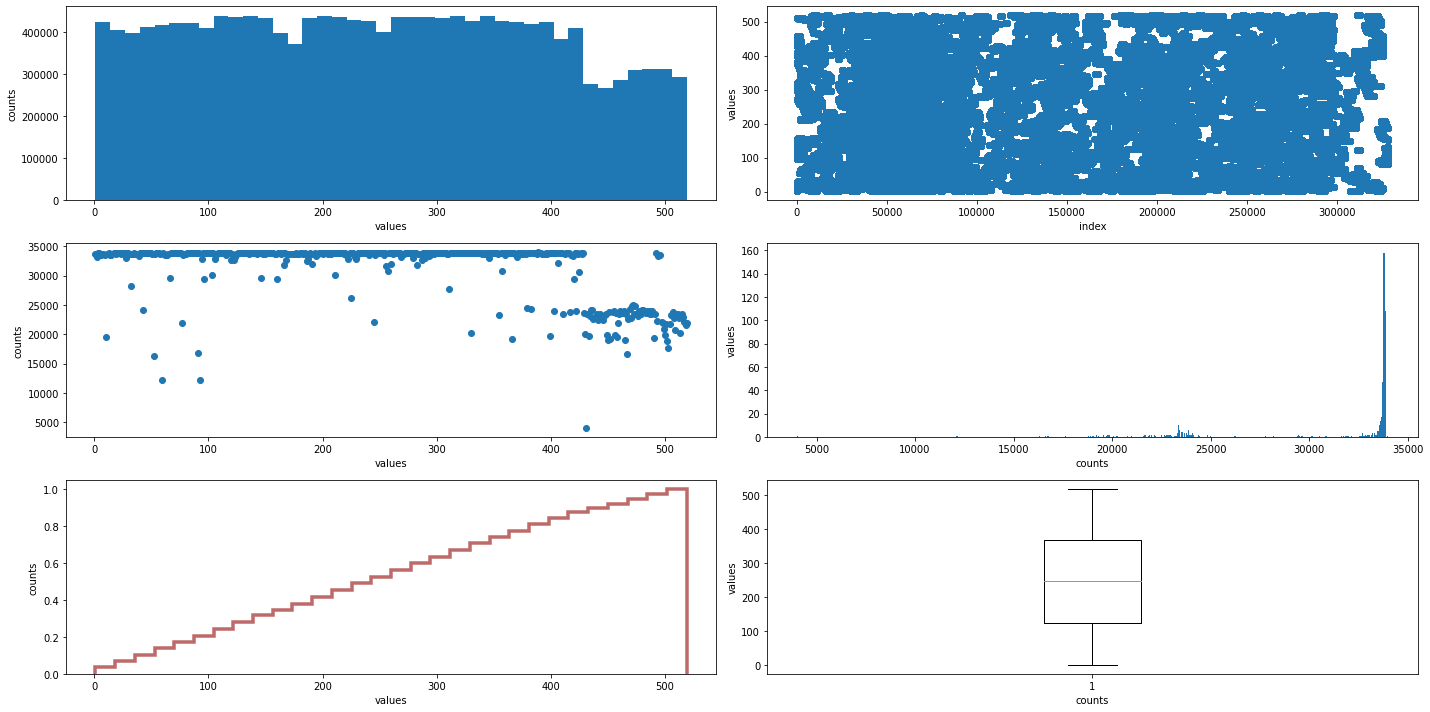

CPU times: user 20.8 s, sys: 1.62 s, total: 22.4 s
Wall time: 26.9 s


In [16]:
%%time

show_counts(bbdd_completa.station_id.compute())

In [17]:
uniques['station_id'].shape

(512,)

In [18]:
unique_ids_by_year = bbdd_completa.groupby('year')['station_id'].unique().compute()
print(unique_ids_by_year)

year
2019    [1, 320, 319, 318, 317, 316, 315, 314, 313, 31...
2020    [1, 301, 300, 299, 14, 298, 297, 296, 295, 294...
2021    [1, 271, 400, 510, 26, 270, 269, 401, 268, 267...
2022    [1, 380, 28, 379, 378, 377, 376, 375, 29, 374,...
Name: station_id, dtype: object


In [19]:
%%time
# Calcula los station_id comunes en todos los años
common_ids = set(unique_ids_by_year[2019])
for year, ids in unique_ids_by_year.items():
    print(year, ids.shape)
    common_ids = common_ids.intersection(set(ids))
# common_ids
print(len(common_ids))

2019 (410,)
2020 (508,)
2021 (509,)
2022 (510,)
408
CPU times: user 1.31 ms, sys: 160 µs, total: 1.47 ms
Wall time: 1.19 ms


In [20]:
filtered_bbdd = bbdd_completa[bbdd_completa['station_id'].isin(common_ids)]

In [21]:
%%time

get_ddf_shape(filtered_bbdd)
#bbdd_completa.shape = (12531377, 23)

CPU times: user 2.72 s, sys: 167 ms, total: 2.89 s
Wall time: 8.51 s


(13695947, 23)

In [22]:
uniques['timestamp'].shape

(34194,)

In [23]:
xticks = np.asanyarray(
    (
        uniques['timestamp'].min(), 
        np.round(uniques['timestamp'].mean()-uniques['timestamp'].std()).astype(int),
        np.round(uniques['timestamp'].mean()).astype(int),
        np.round(uniques['timestamp'].mean()+uniques['timestamp'].std()).astype(int),
        uniques['timestamp'].max()
    )
)
xticks

array([1546300800, 1573332451, 1609940836, 1646549221, 1672527600])

value counts stats {'max': 34003, 'mean': 33568.49754901961, 'median': 33803.0, 'std': 846.0840886142836, 'min': 26248}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 7.95 s, sys: 694 ms, total: 8.65 s
Wall time: 44.2 s


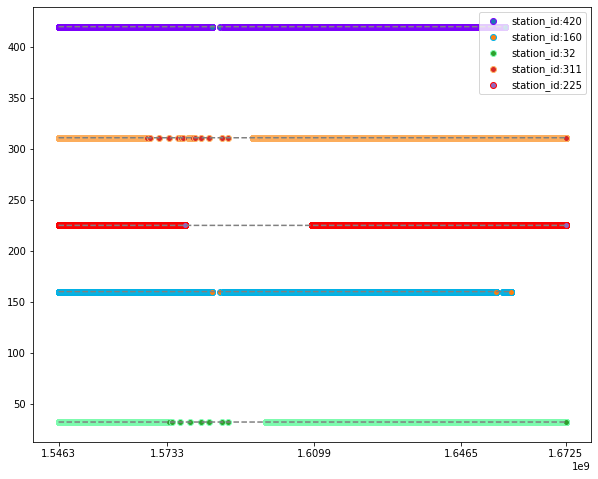

In [24]:
%%time

scatter_columns(
    filtered_bbdd, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8)
)

## IDs no comunes (testing)

In [25]:
nonfiltered_bbdd = bbdd_completa[~bbdd_completa['station_id'].isin(common_ids)]

In [26]:
%%time

get_ddf_shape(nonfiltered_bbdd)
#bbdd_completa.shape = (12531377, 23)

CPU times: user 2.67 s, sys: 152 ms, total: 2.82 s
Wall time: 8.51 s


(2293085, 23)

value counts stats {'max': 25002, 'mean': 22048.89423076923, 'median': 23277.0, 'std': 2973.0699341529876, 'min': 3998}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 7.19 s, sys: 793 ms, total: 7.98 s
Wall time: 41.9 s


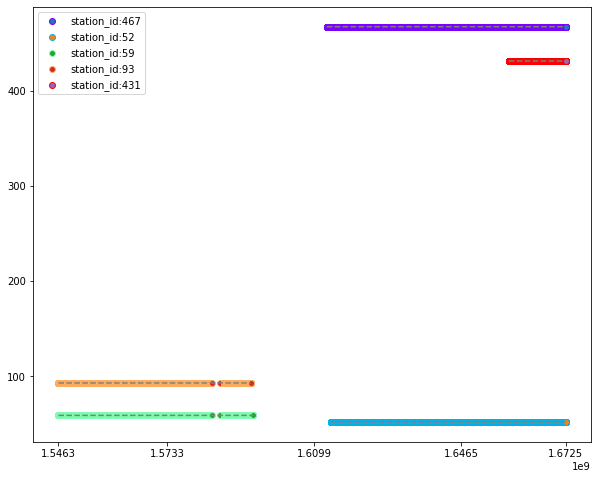

In [27]:
%%time

scatter_columns(
    nonfiltered_bbdd, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8)
)

# Data exploration__________________________________

## · Descriptiva
Media, mediana, desviación estándar, mínimo y máximo para columnas numéricas Idea general de la distribución y el rango de los valores en esas columnas.

<div>
    <table>
        <tr>
            <th><p>Camp<p><th>
            <th><p>Descripció<p><th>
        <tr>
        <tr>
            <td><p>last_updated<p><td>
            <td><p>Timestamp de l'arxiu<p><td>
        <tr>
        <tr>
            <td><p>ttl<p><td>
            <td><p>TimeToLive de la resposta<p><td>
        <tr>
        <tr>
            <td><p>data<p><td>
            <td><p>Contenidor d'arrays d'informació d'estacions<p><td>
        <tr>
        <tr>
            <td><p>stations<p><td>
            <td><p>Array de dades de cada estació<p><td>
        <tr>
        <tr>
            <td><p>station_id<p><td>
            <td><p>Identificador de l'estació<p><td>
        <tr>
        <tr>
            <td><p>num_bikes_available<p><td>
            <td><p>Nombre de bicicletes disponibles<p><td>
        <tr>
        <tr>
            <td><p>num_bikes_available_types<p><td>
            <td><p>Array de tipus de bicicletes disponibles<p><td>
        <tr>
        <tr>
            <td><p>mechanical<p><td>
            <td><p>Nombre de bicicletes mecàniques disponibles<p><td>
        <tr>
        <tr>
            <td><p>ebike<p><td>
            <td><p>Nombre de bicicletes elèctriques disponibles<p><td>
        <tr>
        <tr>
            <td><p>num_docks_available<p><td>
            <td><p>Nombre de ancoratges disponibles<p><td>
        <tr>
        <tr>
            <td><p>is_installed<p><td>
            <td><p>L'estació està correctament instalada (0-NO,1-SI)<p><td>
        <tr>
        <tr>
            <td><p>is_renting<p><td>
            <td><p>L'estació està proporcionant bicicletes correctament<p><td>
        <tr>
        <tr>
            <td><p>is_returning<p><td>
            <td><p>L'estació està ancorant bicicletes correctament<p><td>
        <tr>
        <tr>
            <td><p>last_reported<p><td>
            <td><p>Timestamp de la informació de l'estació<p><td>
        <tr>
        <tr>
            <td><p>is_charging_station<p><td>
            <td><p>L'estació té capacitat de càrrega de bicicletes elèctriques<p><td>
        <tr>
        <tr>
            <td><p>status<p><td>
            <td><p>
                Estat de l'estació (IN_SERVICE=En servei, CLOSED=Tancada)
                 ['IN_SERVICE', 'OPEN', 'OPN', 'CLS', 'CLOSED', 'NOT_IN_SERVICE', 'MAINTENANCE', 'PLANNED']                     [0, 0, 0, 1, 1, 1,  2, 3]
                <p><td>
        <tr>
    <table>
<div>

# Time columns 

## 'timestamp'

DescribeResult(nobs=13695947, minmax=(1546300800, 1672527600), mean=1610620803.8328128, variance=1353616641135981.8, skewness=-0.06851532428616208, kurtosis=-1.2127003883773737)


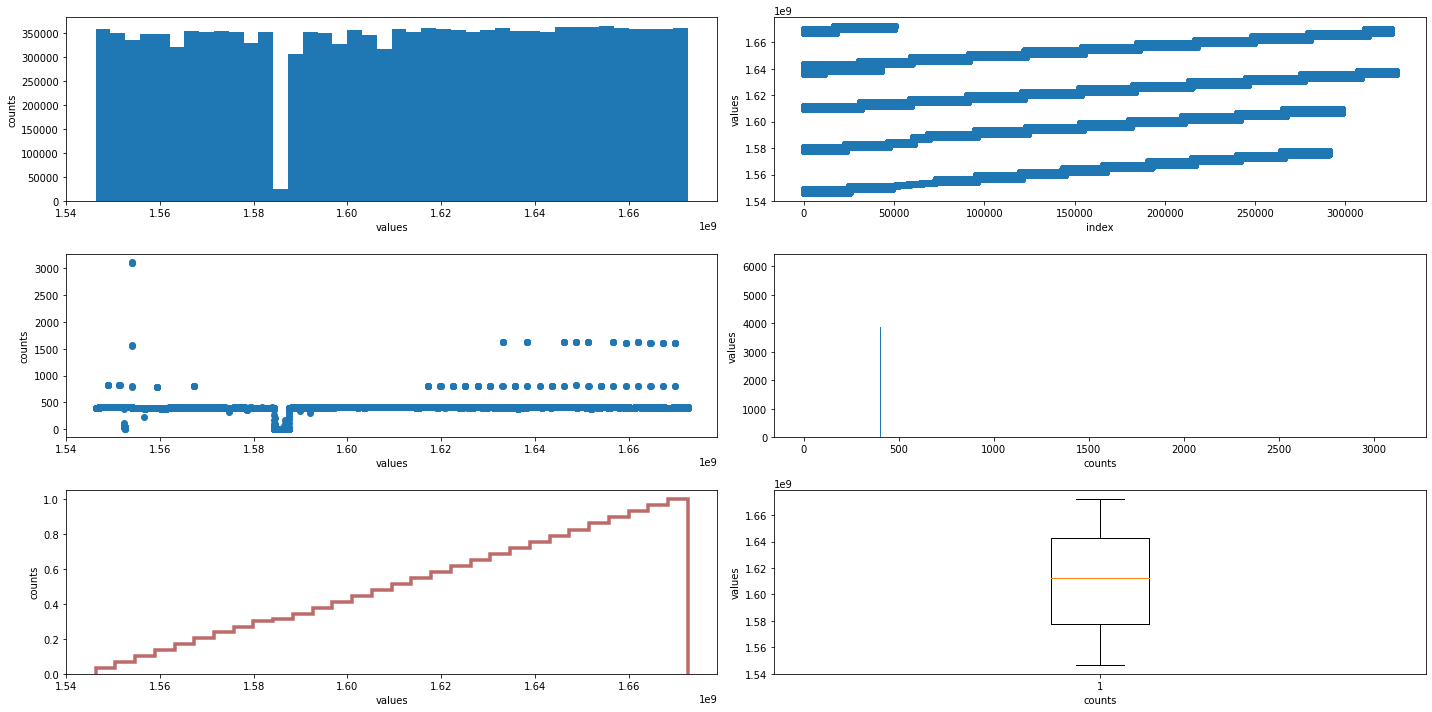

CPU times: user 2min 19s, sys: 27.3 s, total: 2min 46s
Wall time: 3min


In [29]:
%%time
print(stats.describe(filtered_bbdd.timestamp))
filtered_bbdd.timestamp.describe()

show_counts(filtered_bbdd.timestamp.compute())

## 'year' 

DescribeResult(nobs=13695947, minmax=(2019, 2022), mean=2020.531785571308, variance=1.2810948163779952, skewness=-0.05973991118702524, kurtosis=-1.3877630637407383)


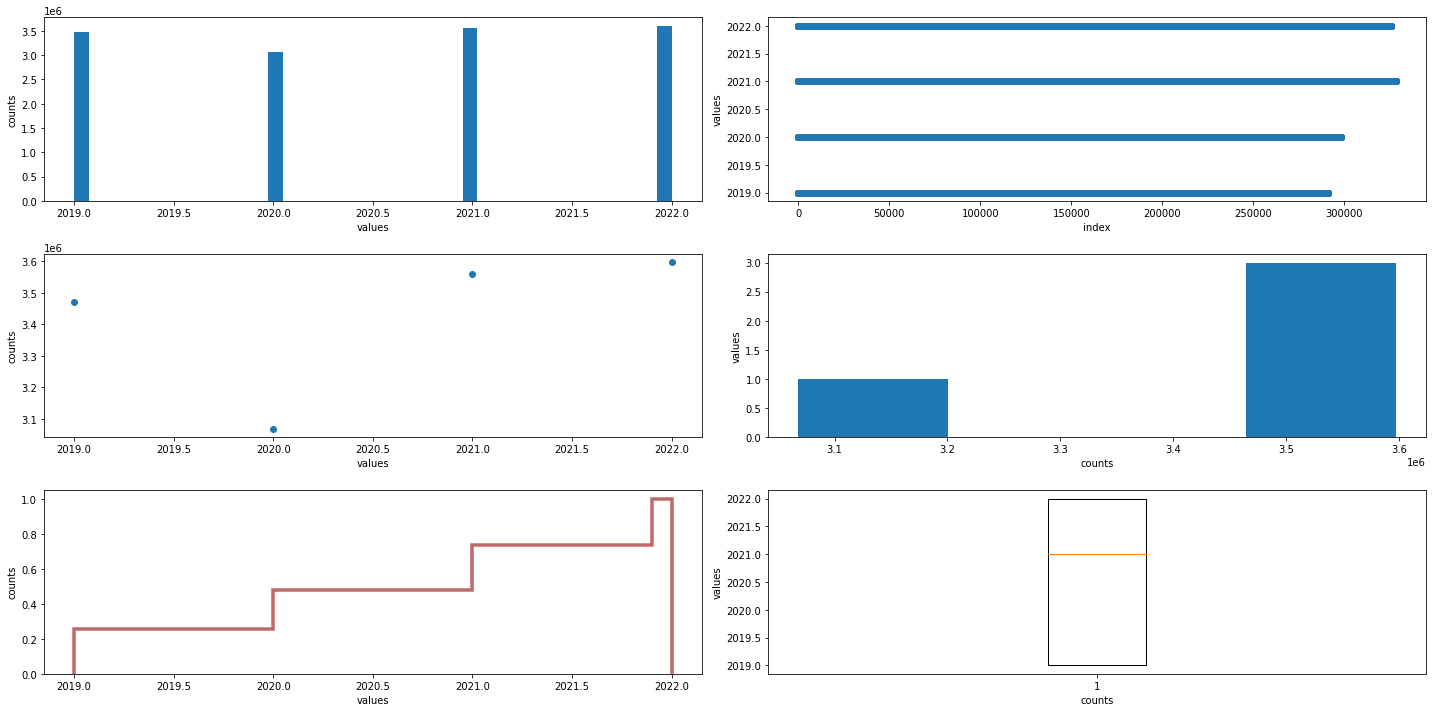

CPU times: user 38.6 s, sys: 4.09 s, total: 42.7 s
Wall time: 1min 2s


In [30]:
%%time
print(stats.describe(filtered_bbdd.year))
filtered_bbdd.year.describe()
show_counts(filtered_bbdd.year.compute())

## 'month'

DescribeResult(nobs=13695947, minmax=(1, 12), mean=6.596964634866066, variance=11.970971522025115, skewness=-0.055679864777547855, kurtosis=-1.2017629693595469)


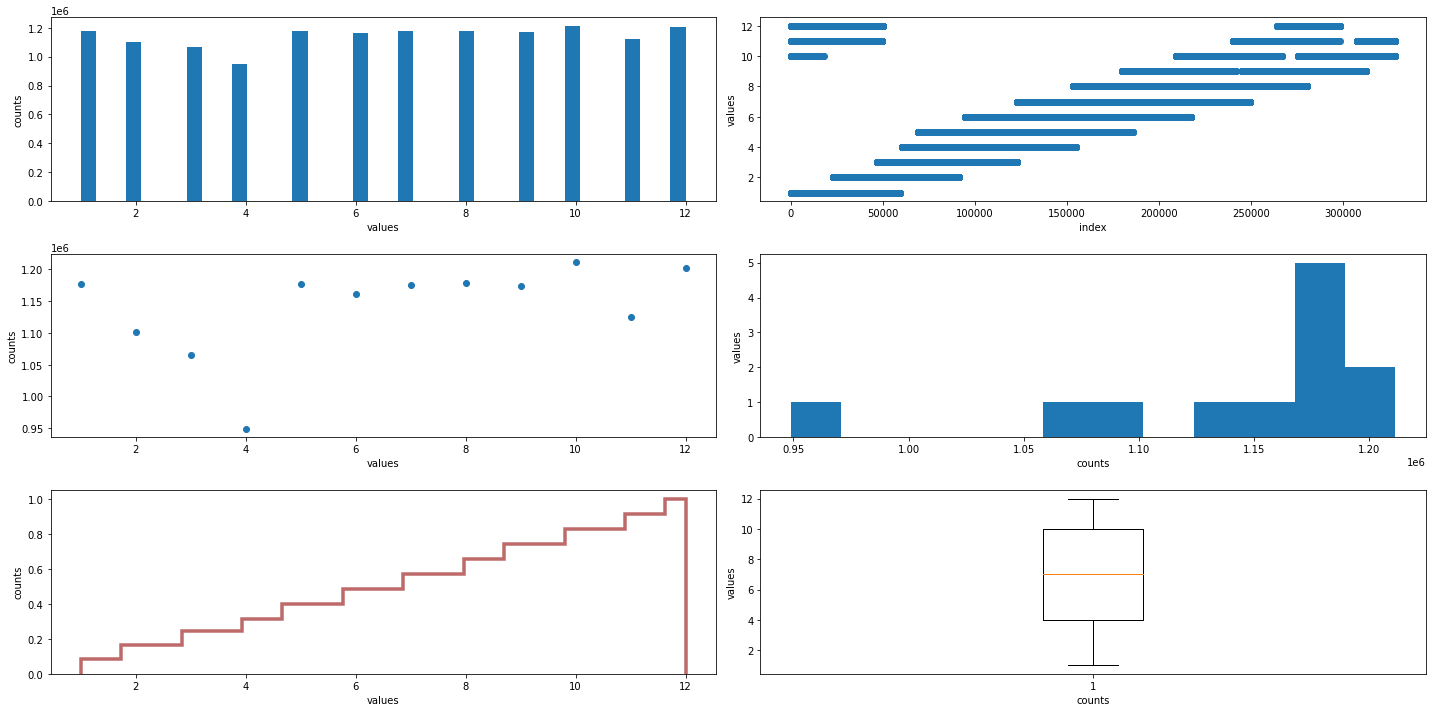

CPU times: user 36.8 s, sys: 3.71 s, total: 40.5 s
Wall time: 59 s


In [31]:
%%time
print(stats.describe(filtered_bbdd.month))
filtered_bbdd.month.describe()
show_counts(filtered_bbdd.month.compute())

## 'dayofweek' 

DescribeResult(nobs=13695947, minmax=(0, 6), mean=2.992969306905174, variance=3.9924149087986, skewness=0.004769799862812546, kurtosis=-1.2475598280214848)


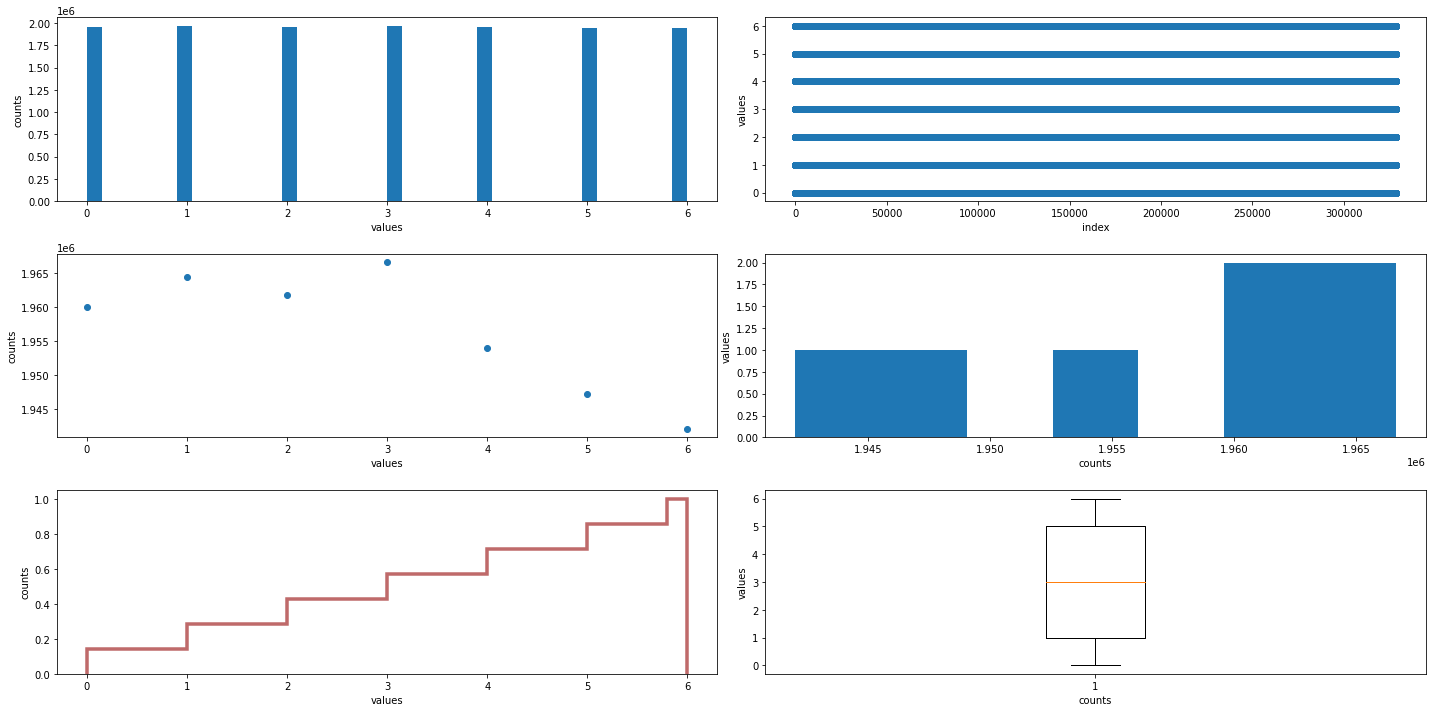

CPU times: user 31.6 s, sys: 2.43 s, total: 34.1 s
Wall time: 50.2 s


In [32]:
%%time
print(stats.describe(filtered_bbdd.dayofweek))
filtered_bbdd.dayofweek.describe()
show_counts(filtered_bbdd.dayofweek.compute())

## 'day'

DescribeResult(nobs=13695947, minmax=(1, 31), mean=15.701012277573795, variance=78.22064786146805, skewness=0.0072689640511584335, kurtosis=-1.188724646064481)


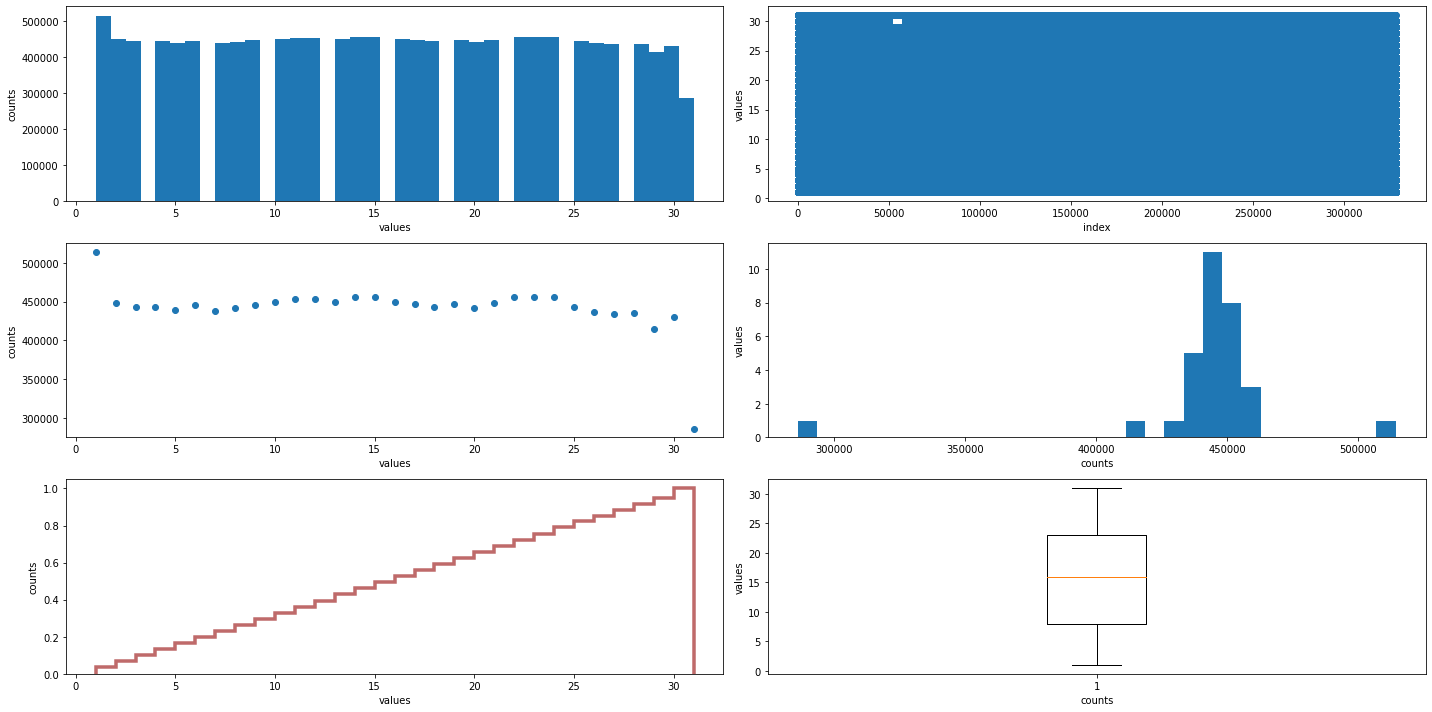

CPU times: user 27.8 s, sys: 2.06 s, total: 29.9 s
Wall time: 44.5 s


In [33]:
%%time
print(stats.describe(filtered_bbdd.day))
filtered_bbdd.day.describe()
show_counts(filtered_bbdd.day.compute())

## 'dayofyear' 

DescribeResult(nobs=13695947, minmax=(1, 366), mean=185.34085711634253, variance=11187.660394319013, skewness=-0.04836758395761228, kurtosis=-1.193248607401424)


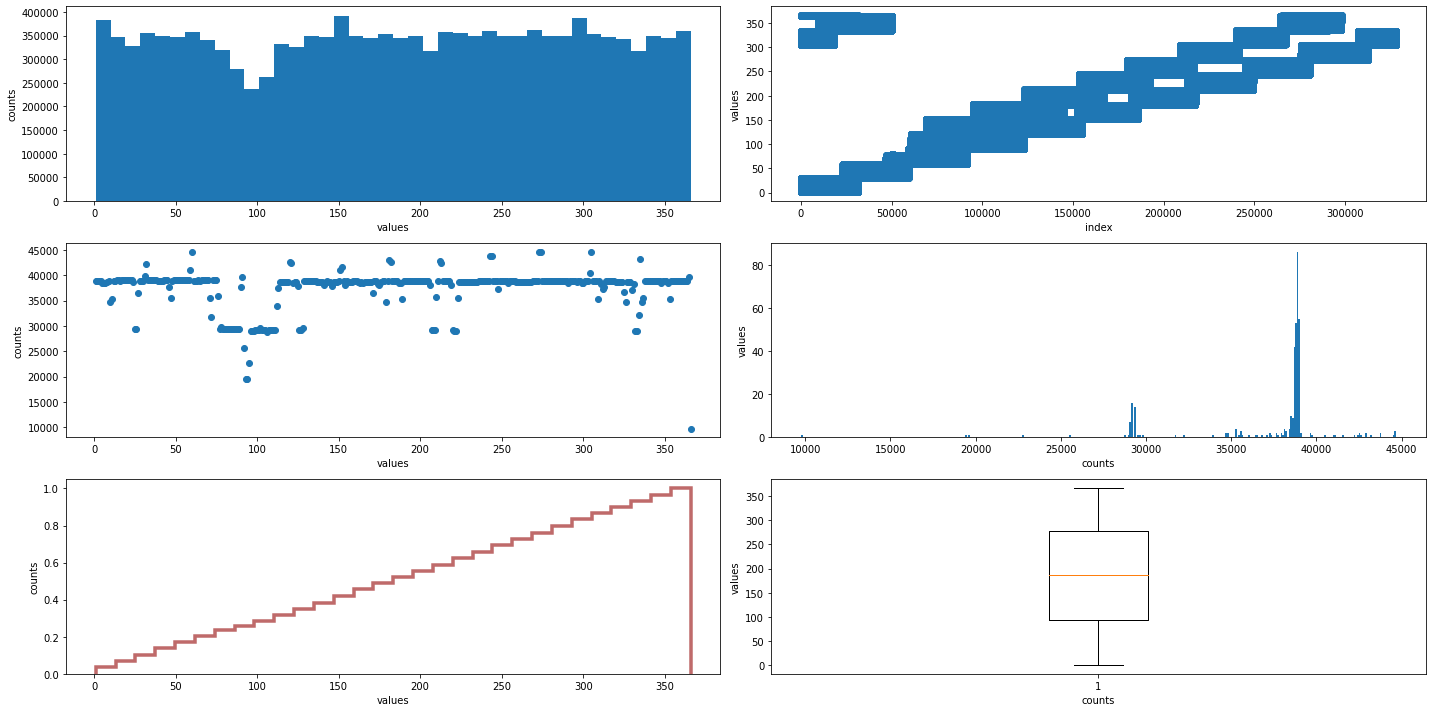

CPU times: user 29.1 s, sys: 2.22 s, total: 31.3 s
Wall time: 45.7 s


In [34]:
%%time
print(stats.describe(filtered_bbdd.dayofyear))
filtered_bbdd.dayofyear.describe()
show_counts(filtered_bbdd.dayofyear.compute())

## 'hour'

DescribeResult(nobs=13695947, minmax=(0, 23), mean=11.503686674605268, variance=48.340680709502074, skewness=-0.001689360207134869, kurtosis=-1.2092637188130513)


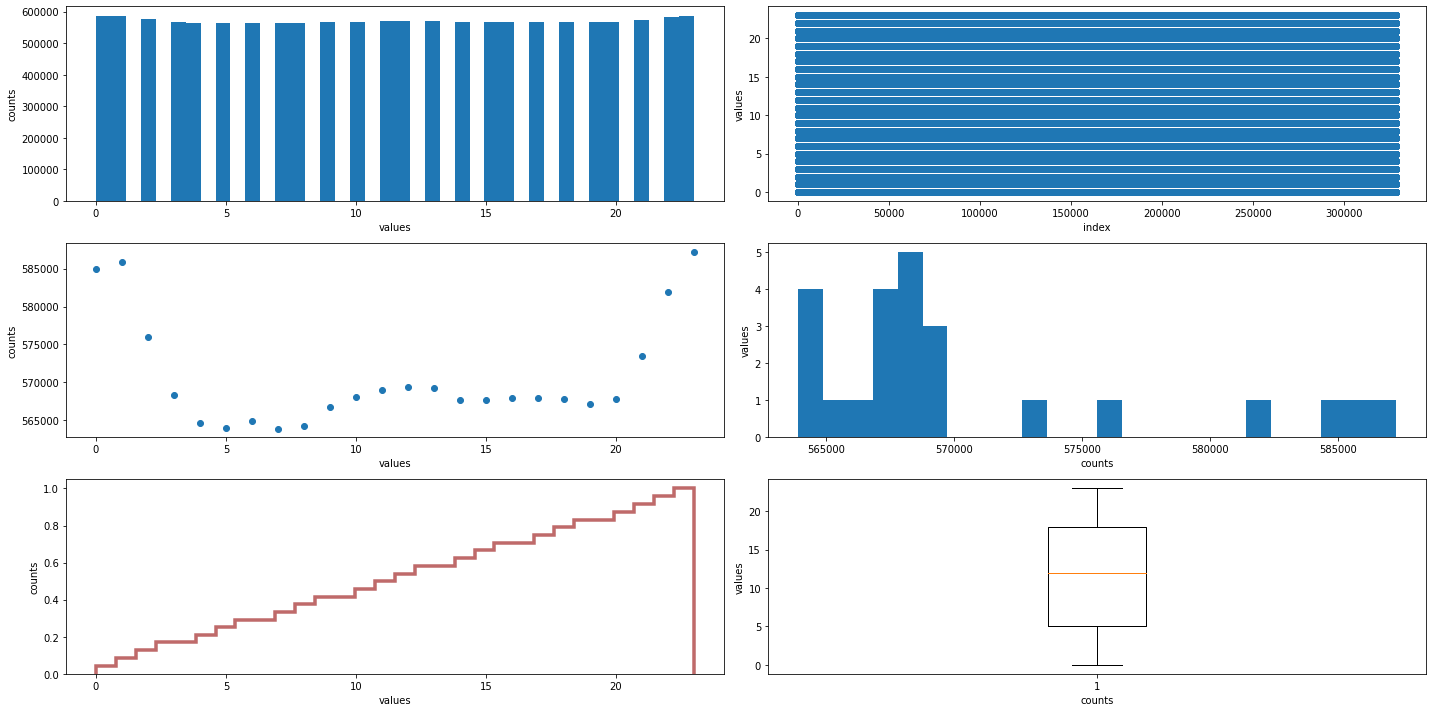

CPU times: user 24.2 s, sys: 1.92 s, total: 26.1 s
Wall time: 41.1 s


In [35]:
%%time
print(stats.describe(filtered_bbdd.hour))
filtered_bbdd.hour.describe()
show_counts(filtered_bbdd.hour.compute())

# Status Columns 

## 'status'

DescribeResult(nobs=13695947, minmax=(0, 3), mean=0.03460994701571202, variance=0.03599563924648927, skewness=5.69942409550984, kurtosis=34.89012764781221)


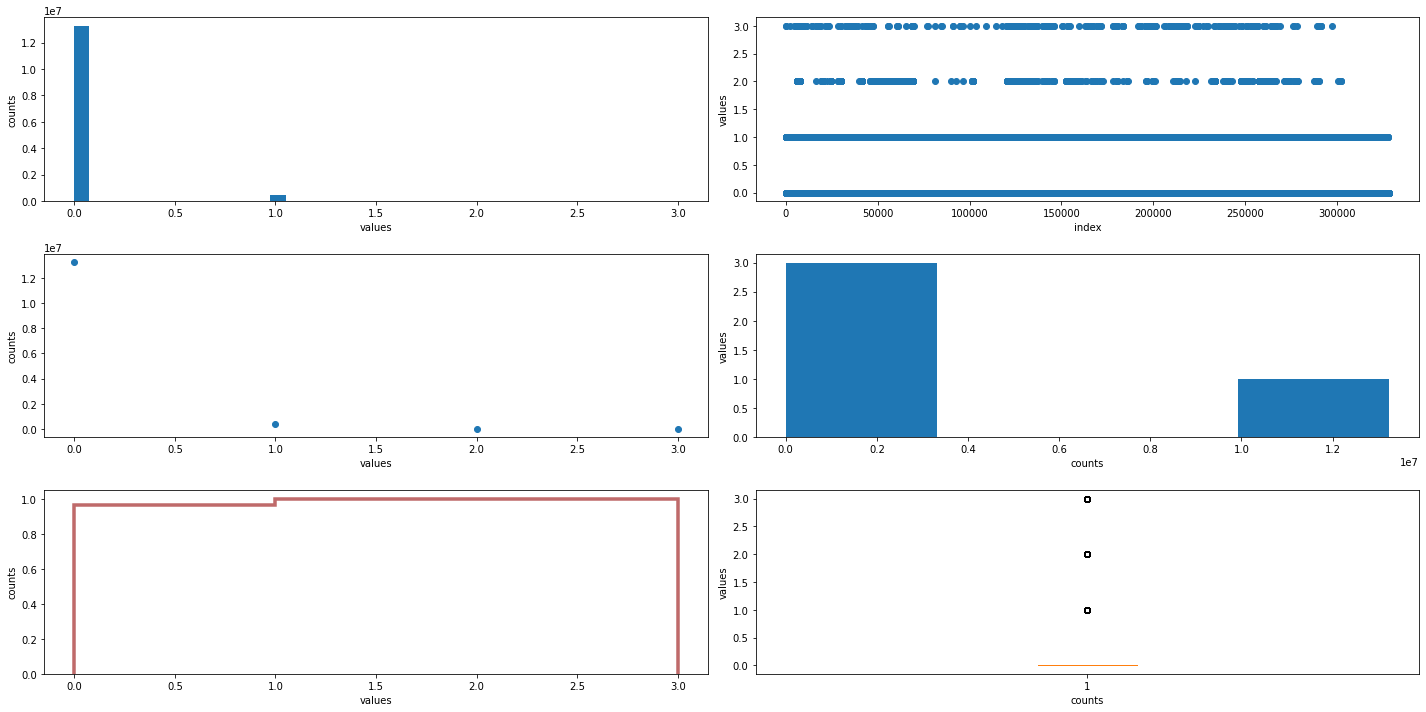

CPU times: user 28.8 s, sys: 2.62 s, total: 31.5 s
Wall time: 45.9 s


In [36]:
%%time
print(stats.describe(filtered_bbdd.status))
filtered_bbdd.status.describe()
show_counts(filtered_bbdd.status.compute())

## 'is_installed'

DescribeResult(nobs=13695947, minmax=(0, 1), mean=0.9999391060727674, variance=6.08902236081191e-05, skewness=-128.1366413710492, kurtosis=16416.998861855525)


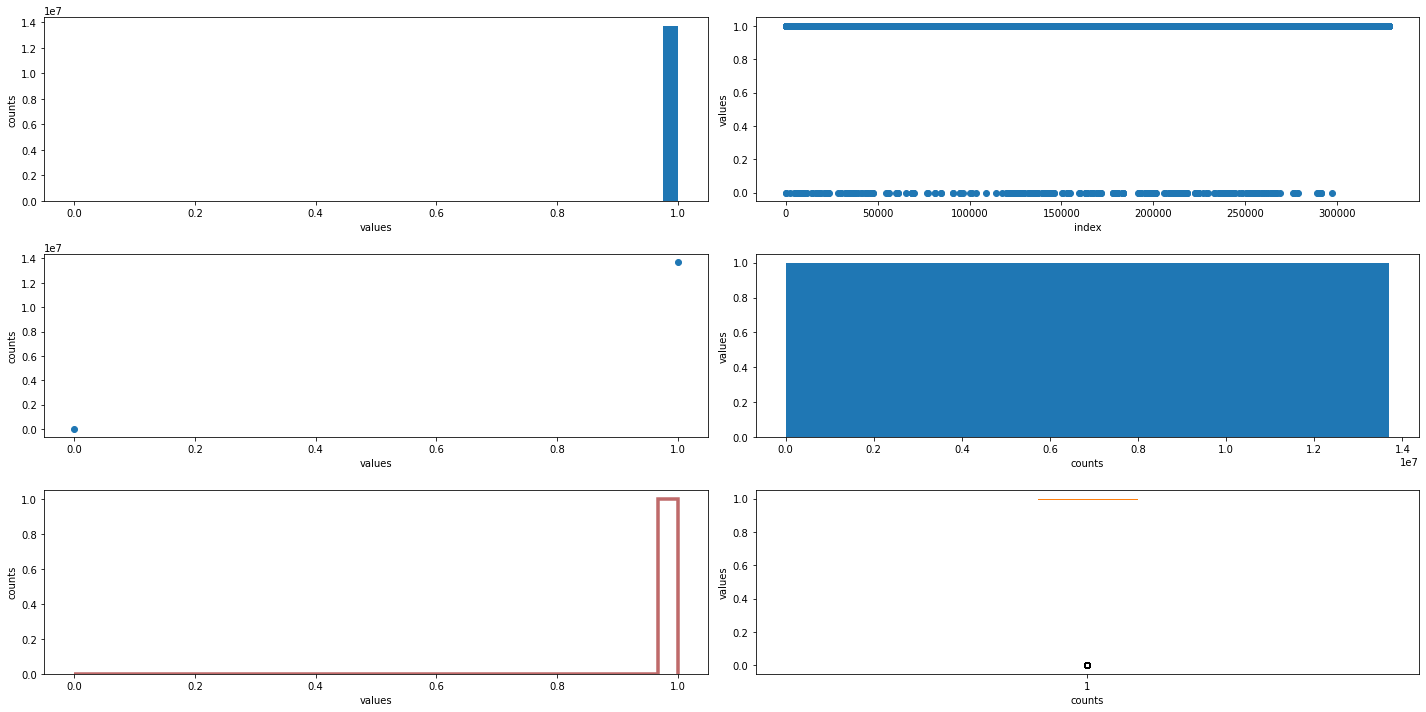

CPU times: user 28 s, sys: 2.77 s, total: 30.8 s
Wall time: 45.9 s


In [37]:
%%time
print(stats.describe(filtered_bbdd.is_installed))
filtered_bbdd.is_installed.describe()
show_counts(filtered_bbdd.is_installed.compute())

## 'is_renting'

DescribeResult(nobs=13695947, minmax=(0, 1), mean=0.9980996567816741, variance=0.001896732052466933, skewness=-22.87406033650052, kurtosis=521.2226362778562)


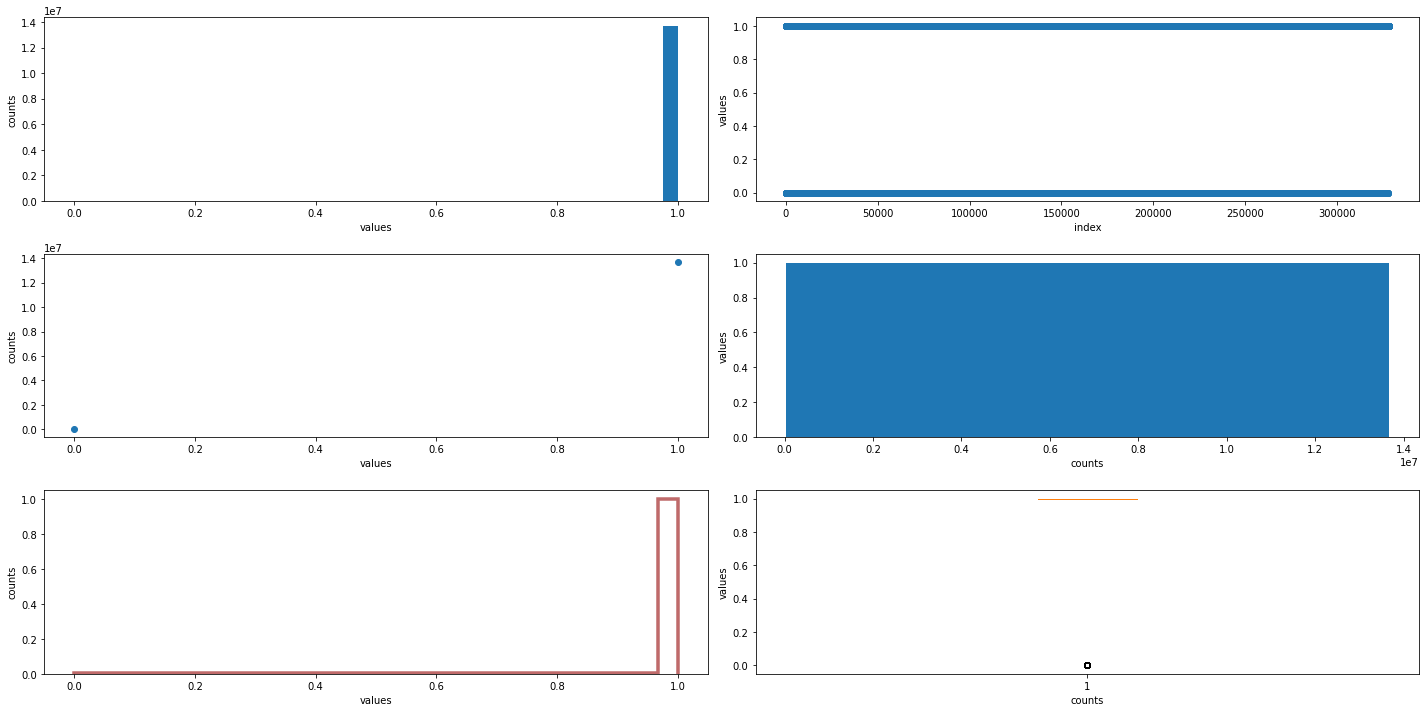

CPU times: user 29.9 s, sys: 2.8 s, total: 32.7 s
Wall time: 48.8 s


In [38]:
%%time
print(stats.describe(filtered_bbdd.is_renting))
filtered_bbdd.is_renting.describe()
show_counts(filtered_bbdd.is_renting.compute())

## 'is_returning'

DescribeResult(nobs=13695947, minmax=(0, 1), mean=0.9981293736022782, variance=0.0018671272909290503, skewness=-23.056065643752813, kurtosis=529.5821629690406)


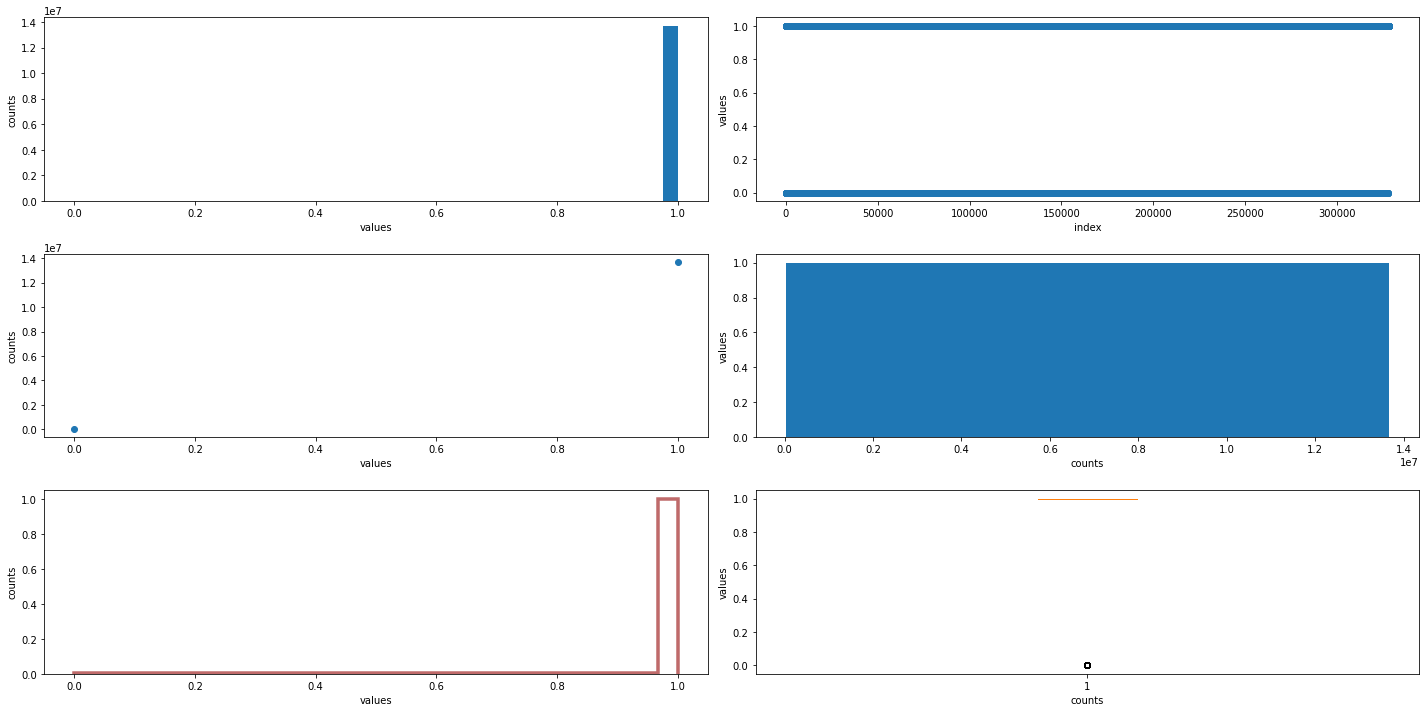

CPU times: user 30.7 s, sys: 2.85 s, total: 33.6 s
Wall time: 50.2 s


In [39]:
%%time
print(stats.describe(filtered_bbdd.is_returning))
filtered_bbdd.is_returning.describe()
show_counts(filtered_bbdd.is_returning.compute())

## 'is_charging_station'

DescribeResult(nobs=13695947, minmax=(1, 1), mean=1.0, variance=0.0, skewness=0.0, kurtosis=-3.0)


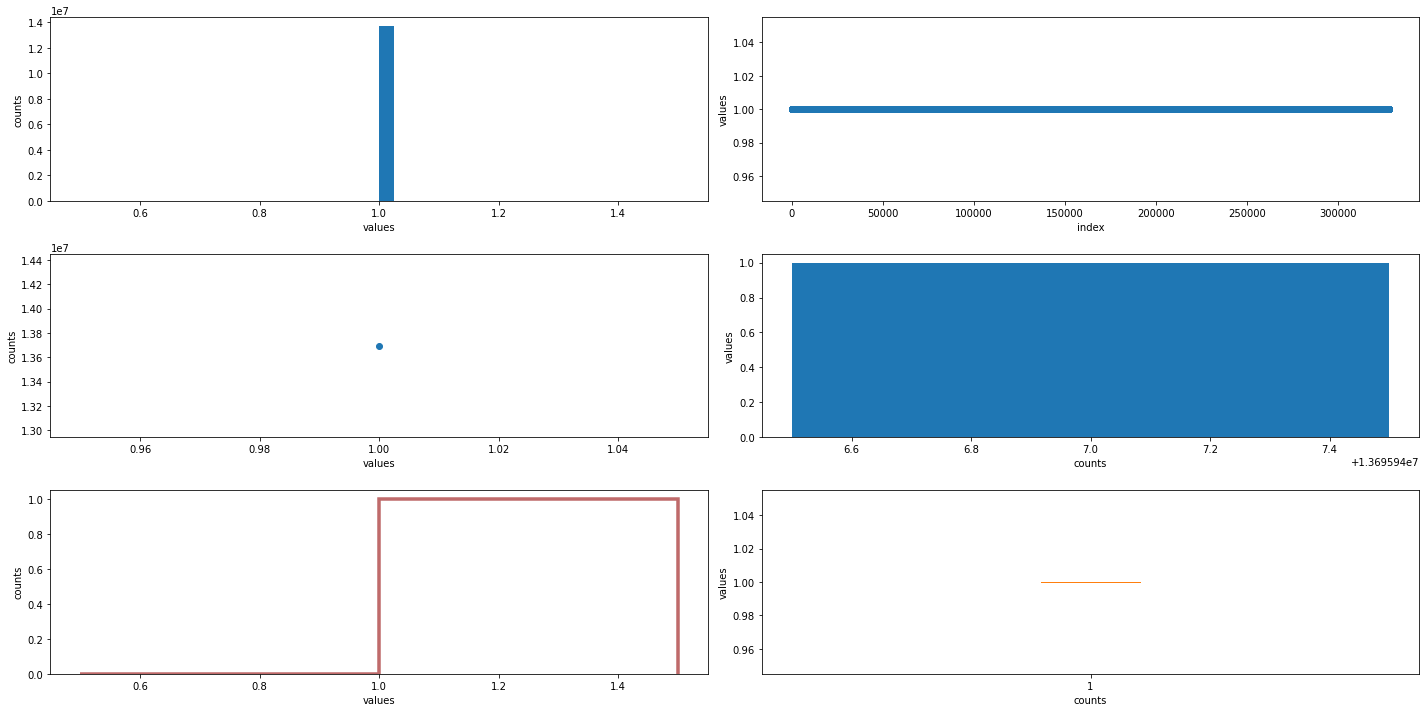

CPU times: user 30.2 s, sys: 2.86 s, total: 33.1 s
Wall time: 49.8 s


In [40]:
%%time
print(stats.describe(filtered_bbdd.is_charging_station))
filtered_bbdd.is_charging_station.describe()
show_counts(filtered_bbdd.is_charging_station.compute())

## Study 

In [41]:
def filter_data(data, row_data, row_index):
    cat_cols = row_data.select_dtypes(include=['object']).columns
    num_cols = row_data.select_dtypes(exclude=['object']).columns
    
    filtered = data.copy()
    
    row = row_data.loc[row_index]
    for num_col in num_cols:
        filtered = filtered[filtered[num_col] == row[num_col]]
    
    for cat_col in cat_cols:
        filtered = filtered[filtered[cat_col].isin(row[cat_col])]
    
    return filtered

In [42]:
filtered_bbdd.groupby(
    [         
        'status',
        'is_installed',
        'is_renting', 
        'is_returning'
    ]
).station_id.sum().compute().reset_index().sort_values(['status','is_installed','is_renting','is_returning']).reset_index(drop=True)


,status,is_installed,is_renting,is_returning,station_id
0,0,1,0,0,161415
1,0,1,0,1,57835
2,0,1,1,1,2863264451
3,1,1,0,0,1934343
4,1,1,0,1,27493
5,1,1,1,1,94538323
6,2,0,0,0,11356
7,2,1,0,0,3438953
8,3,0,0,0,147565
9,3,1,1,1,494


In [43]:
status_of_station = filtered_bbdd.groupby(
    [         
        'status',
        'is_installed',
        'is_renting', 
        'is_returning'
    ]
)['station_id'].unique().compute()

status_of_station = pd.DataFrame(status_of_station).reset_index()
status_of_station = status_of_station.sort_values(['status','is_installed','is_renting','is_returning']).reset_index(drop=True)
status_of_station

,status,is_installed,is_renting,is_returning,station_id
0,0,1,0,0,"[396, 222, 89, 184, 351, 187, 424, 307, 23, 12..."
1,0,1,0,1,"[94, 352, 223, 42, 351, 404, 78, 220, 345, 61,..."
2,0,1,1,1,"[1, 320, 319, 318, 317, 316, 315, 314, 313, 31..."
3,1,1,0,0,"[332, 346, 344, 42, 339, 298, 290, 71, 352, 13..."
4,1,1,0,1,"[348, 347, 405, 297, 296, 318, 288, 284, 334, ..."
5,1,1,1,1,"[1, 318, 311, 310, 321, 307, 305, 304, 302, 29..."
6,2,0,0,0,"[194, 106, 311, 387, 205, 170, 225, 375, 406, ..."
7,2,1,0,0,"[54, 373, 208, 89, 349, 272, 377, 133, 346, 36..."
8,3,0,0,0,"[406, 171, 74, 123, 51, 256, 425, 310, 419, 38..."
9,3,1,1,1,[494]


In [47]:
## view of the stations status

value counts stats {'max': 8, 'mean': 2.288184438040346, 'median': 2.0, 'std': 1.4051737145977476, 'min': 1}


  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 1min 56s, sys: 13.5 s, total: 2min 9s
Wall time: 5min 3s


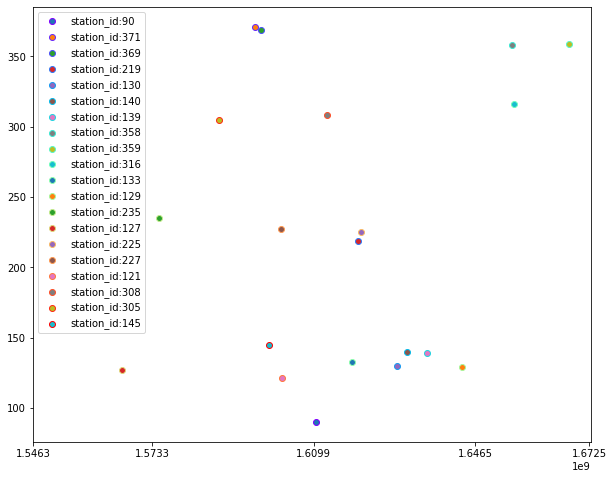

In [44]:
%%time

# case of station with opened status and is installed but it is not renting and not returning
filtered = filter_data(filtered_bbdd, status_of_station, 0)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8),
    count=20
)

value counts stats {'max': 14, 'mean': 1.1612903225806452, 'median': 1.0, 'std': 1.0521337269750384, 'min': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 33.8 s, sys: 3.65 s, total: 37.4 s
Wall time: 1min 27s


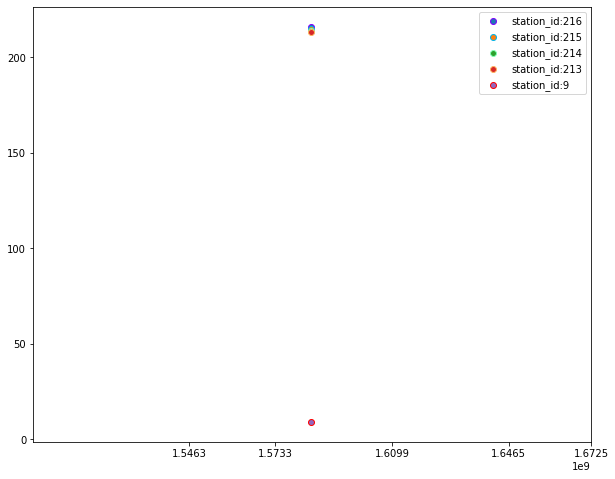

In [45]:
%%time

# case of station with opened status and is installed and is renting and returning
filtered = filter_data(filtered_bbdd, status_of_station, 1)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8),
    count=5
)

value counts stats {'max': 33598, 'mean': 32445.406862745098, 'median': 32569.0, 'std': 999.295555885122, 'min': 25808}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 48.4 s, sys: 5.49 s, total: 53.9 s
Wall time: 1min 54s


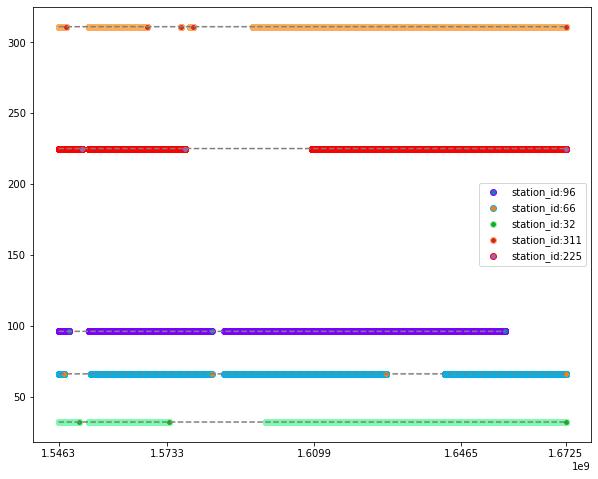

In [46]:
%%time
# case of station with opened status and is installed and is renting and returning
filtered = filter_data(filtered_bbdd, status_of_station, 2)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8),
    count=5
)

value counts stats {'max': 148, 'mean': 21.306372549019606, 'median': 16.0, 'std': 18.596101638404715, 'min': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 48.2 s, sys: 6.01 s, total: 54.3 s
Wall time: 1min 47s


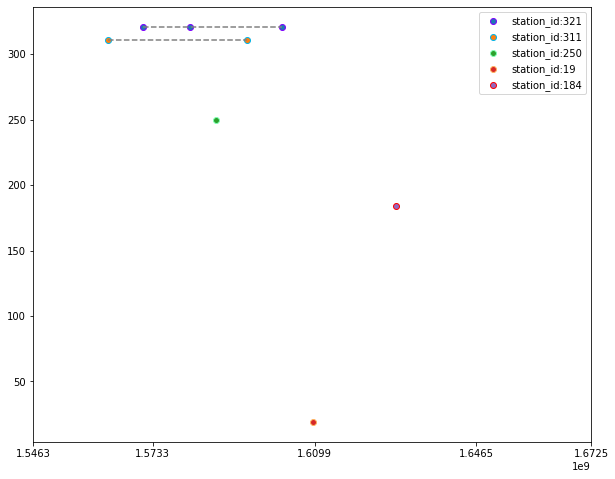

In [48]:
%%time
# case of station with opened status and is installed and is renting and returning
filtered = filter_data(filtered_bbdd, status_of_station, 3)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8),
    count=5
)

value counts stats {'max': 1, 'mean': 1.0, 'median': 1.0, 'std': 0.0, 'min': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 44.8 s, sys: 5.77 s, total: 50.5 s
Wall time: 1min 45s


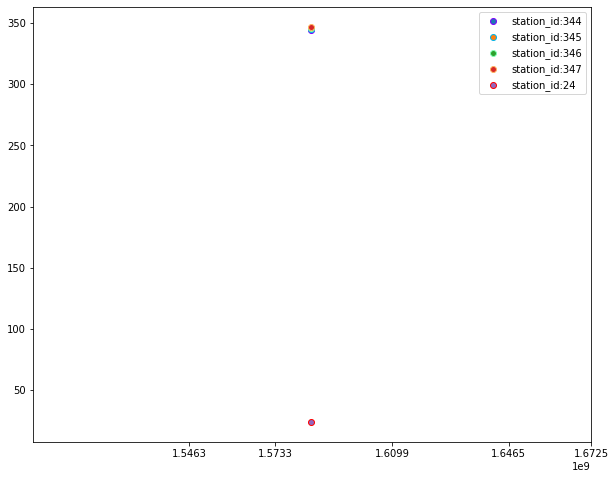

In [49]:
%%time
# case of station with opened status and is installed and is renting and returning
filtered = filter_data(filtered_bbdd, status_of_station, 4)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8),
    count=5
)

value counts stats {'max': 2129, 'mean': 1059.296568627451, 'median': 1046.0, 'std': 521.6437663350878, 'min': 181}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 46.3 s, sys: 5.81 s, total: 52.1 s
Wall time: 1min 47s


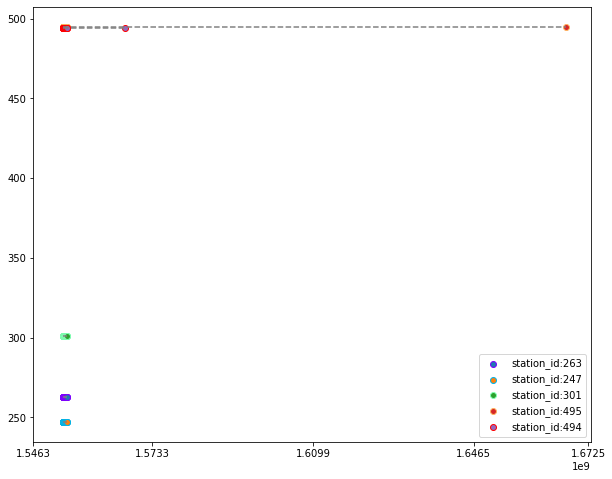

In [50]:
%%time
# case of station with opened status and is installed and is renting and returning
filtered = filter_data(filtered_bbdd, status_of_station, 5)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8),
    count=5
)

value counts stats {'max': 2, 'mean': 1.1914893617021276, 'median': 1.0, 'std': 0.39772712255364373, 'min': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 50.4 s, sys: 7.31 s, total: 57.7 s
Wall time: 1min 53s


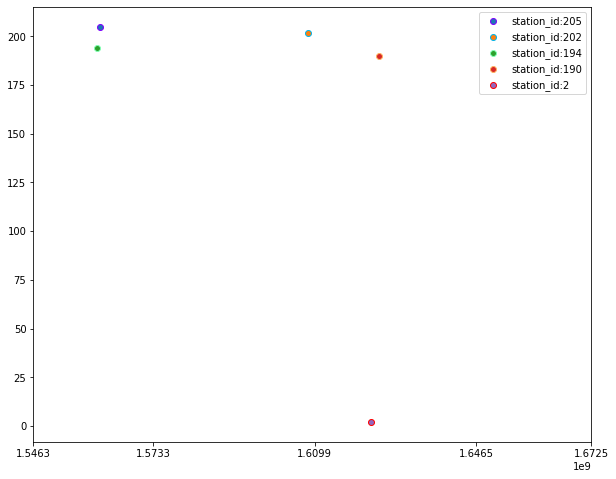

In [51]:
%%time
# case of station with opened status and is installed and is renting and returning
filtered = filter_data(filtered_bbdd, status_of_station, 6)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8),
    count=5
)

value counts stats {'max': 608, 'mean': 37.77530864197531, 'median': 39.0, 'std': 31.320625265878604, 'min': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 34.3 s, sys: 3.59 s, total: 37.9 s
Wall time: 1min 25s


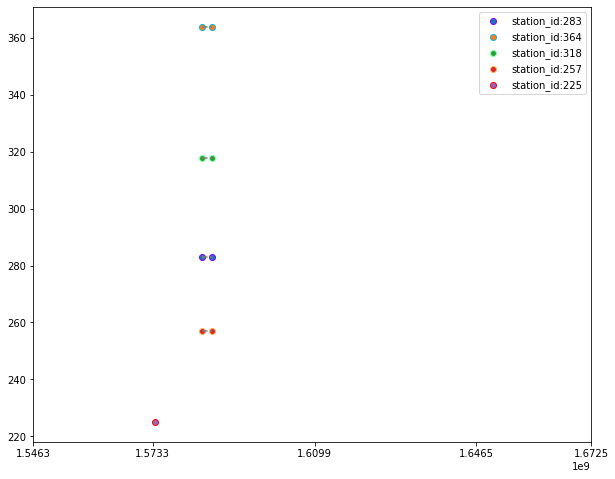

In [52]:
%%time
# case of station with opened status and is installed and is renting and returning
filtered = filter_data(filtered_bbdd, status_of_station, 7)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8),
    count=5
)

value counts stats {'max': 381, 'mean': 6.274193548387097, 'median': 2.0, 'std': 34.15444089247667, 'min': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 35.2 s, sys: 3.75 s, total: 39 s
Wall time: 1min 26s


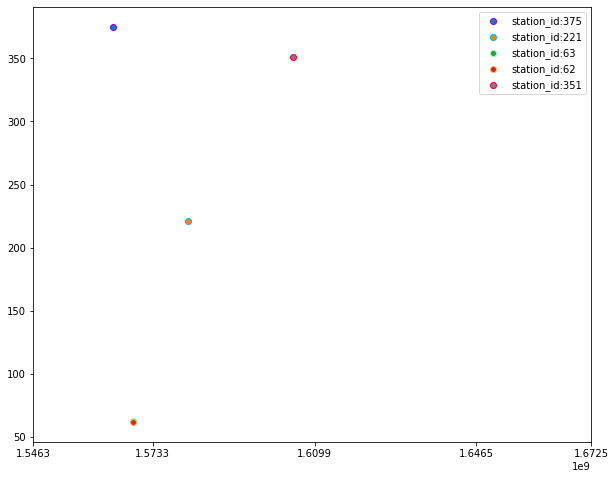

In [53]:
%%time
# case of station with opened status and is installed and is renting and returning
filtered = filter_data(filtered_bbdd, status_of_station, 8)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8),
    count=5
)

value counts stats {'max': 1, 'mean': 1.0, 'median': 1.0, 'std': nan, 'min': 1}


  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 10.4 s, sys: 1.39 s, total: 11.8 s
Wall time: 27.5 s


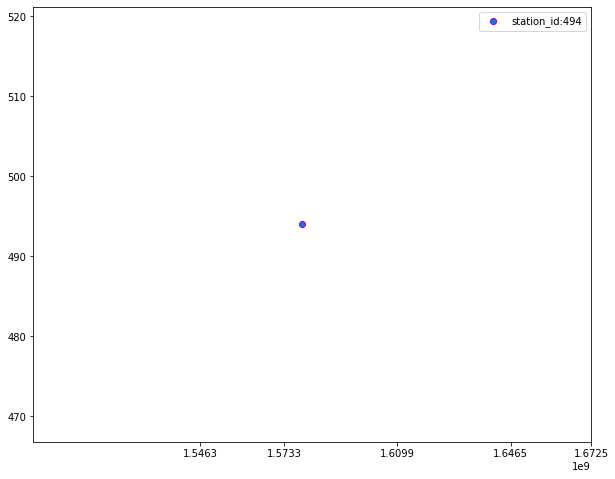

In [54]:
%%time
# case of station with opened status and is installed and is renting and returning
filtered = filter_data(filtered_bbdd, status_of_station, 9)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8),
    count=5
)

# Goal Columns 

## 'num_docks_available' 

DescribeResult(nobs=13695947, minmax=(0.0, 54.0), mean=15.629690146796907, variance=74.61441850675214, skewness=0.12741598772394702, kurtosis=-0.2926192514767769)


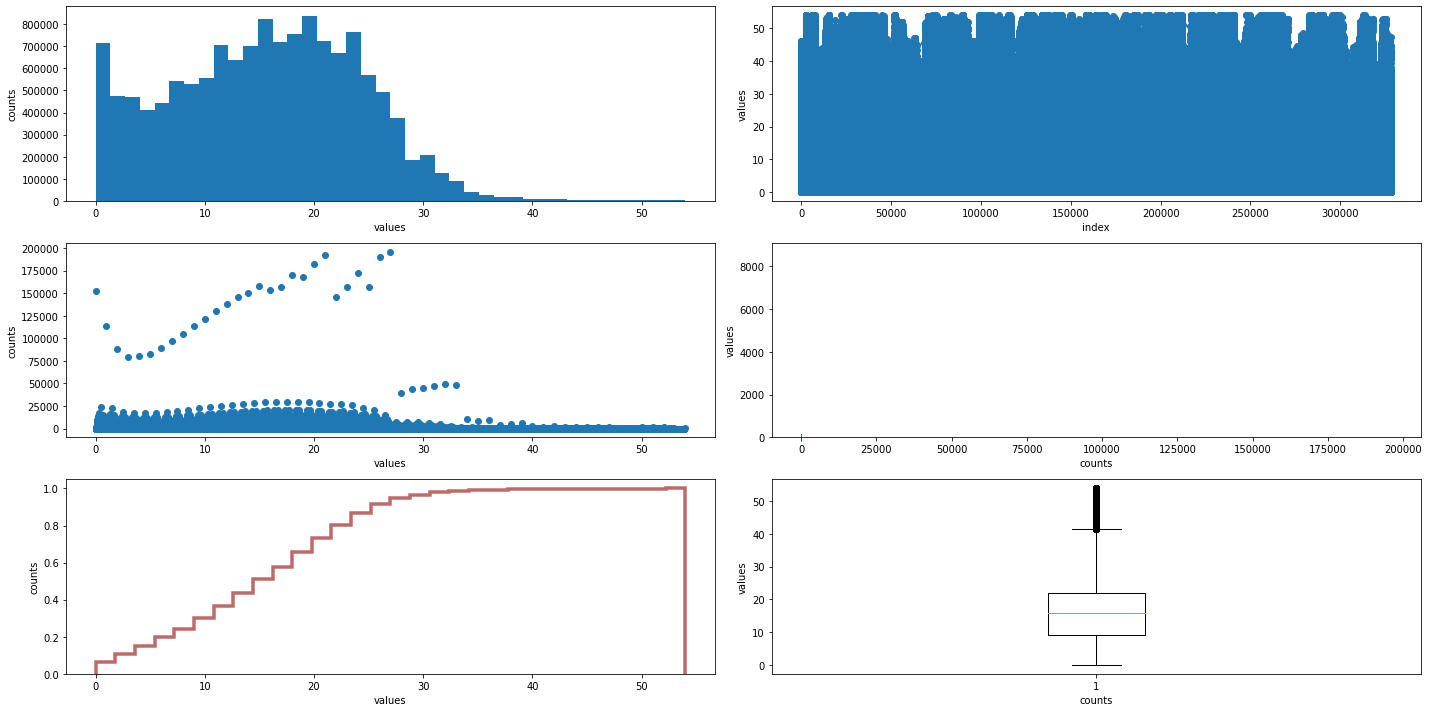

CPU times: user 51.2 s, sys: 5.24 s, total: 56.4 s
Wall time: 1min 13s


In [55]:
%%time
print(stats.describe(filtered_bbdd.num_docks_available))
filtered_bbdd.num_docks_available.describe()
show_counts(filtered_bbdd.num_docks_available.compute())

## 'num_bikes_available' 

DescribeResult(nobs=13695947, minmax=(-0.16666666666666666, 54.0), mean=10.02899408945014, variance=70.17026611982996, skewness=0.8351080921317587, kurtosis=0.43797686322691964)


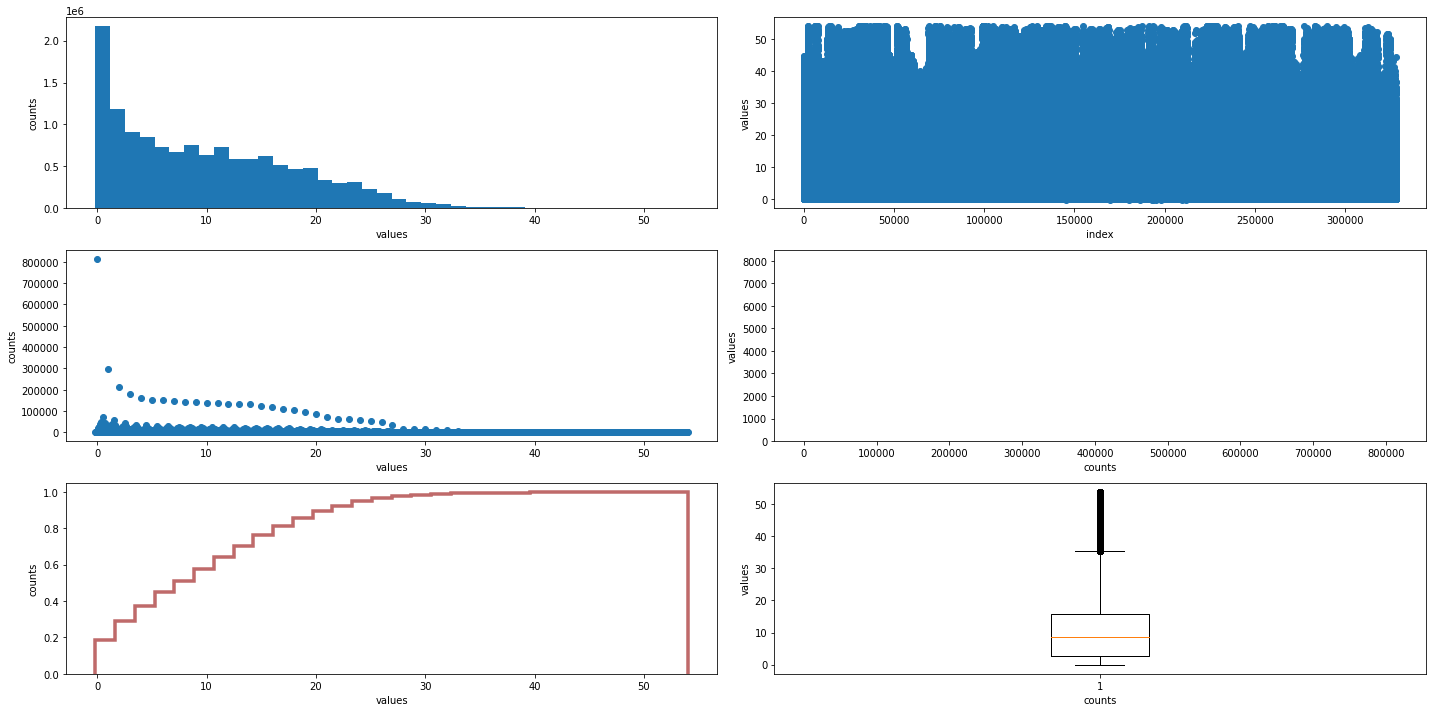

CPU times: user 47.5 s, sys: 4.69 s, total: 52.2 s
Wall time: 1min 8s


In [56]:
%%time
print(stats.describe(filtered_bbdd.num_bikes_available))
filtered_bbdd.num_bikes_available.describe()
show_counts(filtered_bbdd.num_bikes_available.compute())

## 'num_bikes_available_types.mechanical'

DescribeResult(nobs=13695947, minmax=(-0.16666666666666666, 54.0), mean=8.531965556083117, variance=66.16111485819096, skewness=0.968257059985819, kurtosis=0.6092348705468034)


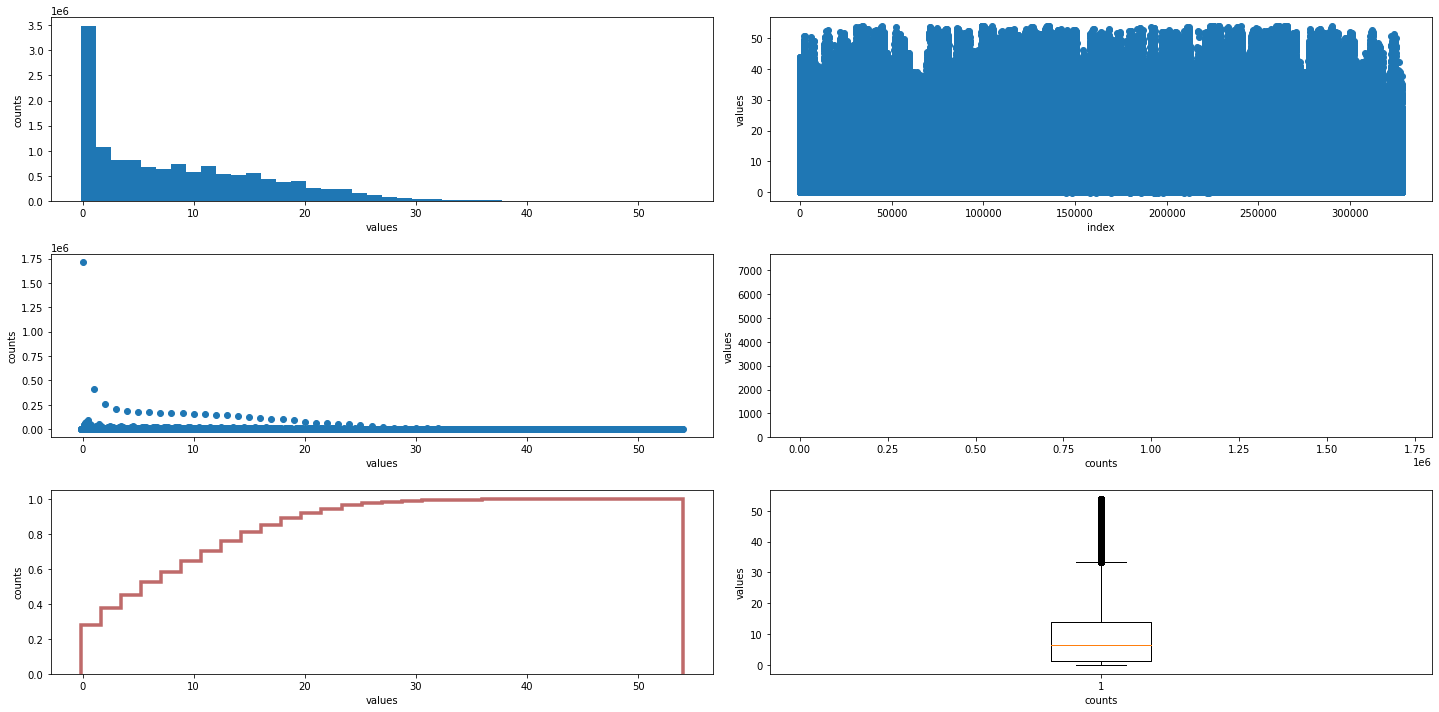

CPU times: user 48.6 s, sys: 4.89 s, total: 53.5 s
Wall time: 1min 9s


In [57]:
%%time
print(stats.describe(filtered_bbdd['num_bikes_available_types.mechanical']))
filtered_bbdd['num_bikes_available_types.mechanical'].describe()
show_counts(filtered_bbdd['num_bikes_available_types.mechanical'].compute())

## 'num_bikes_available_types.ebike'

DescribeResult(nobs=13695947, minmax=(0.0, 37.0), mean=1.4970636002284774, variance=6.532202434192713, skewness=3.3120160593375543, kurtosis=14.946122102263278)


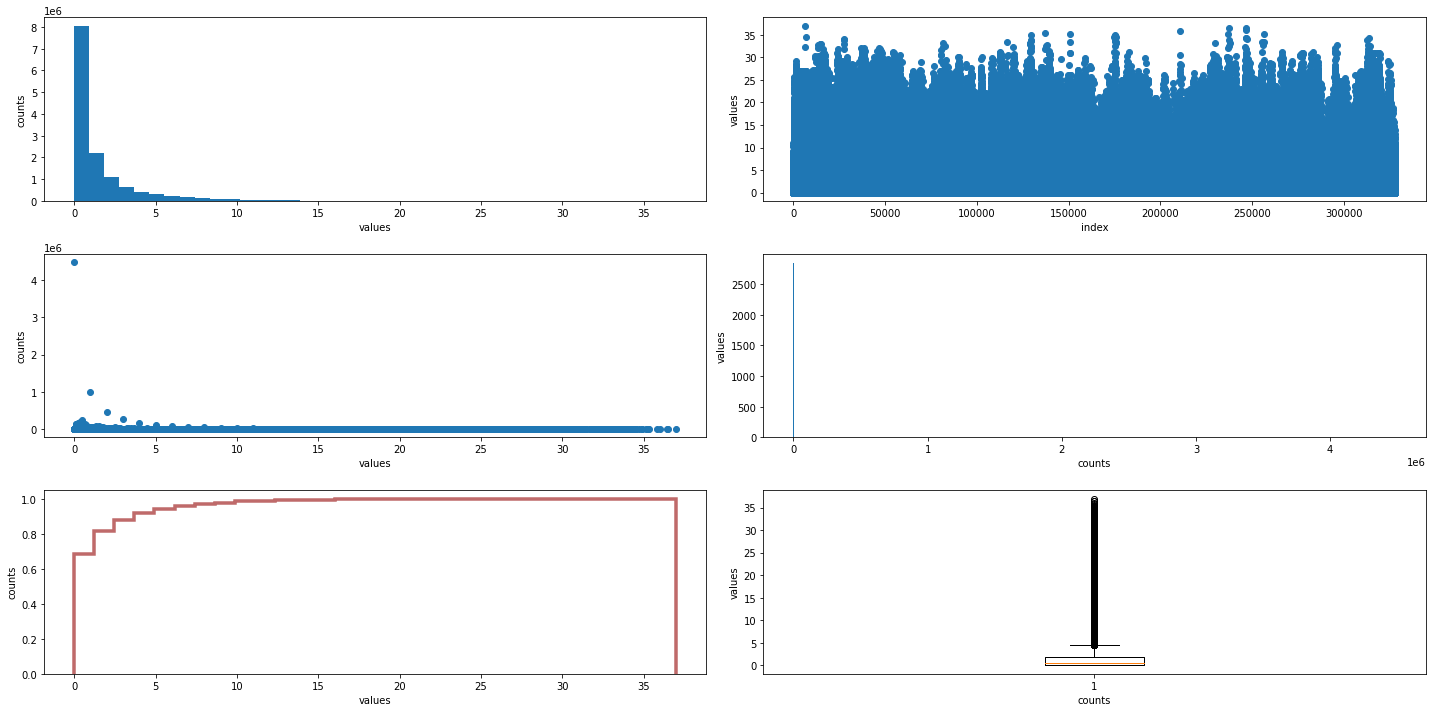

CPU times: user 42 s, sys: 4.21 s, total: 46.2 s
Wall time: 1min 4s


In [58]:
%%time
print(stats.describe(filtered_bbdd['num_bikes_available_types.ebike']))
filtered_bbdd['num_bikes_available_types.ebike'].describe()
show_counts(filtered_bbdd['num_bikes_available_types.ebike'].compute())

## 'capacity' 

DescribeResult(nobs=13695947, minmax=(12.000000000000005, 54.2), mean=27.41080248430351, variance=36.74892465052911, skewness=1.3103187820384732, kurtosis=3.784280741806337)


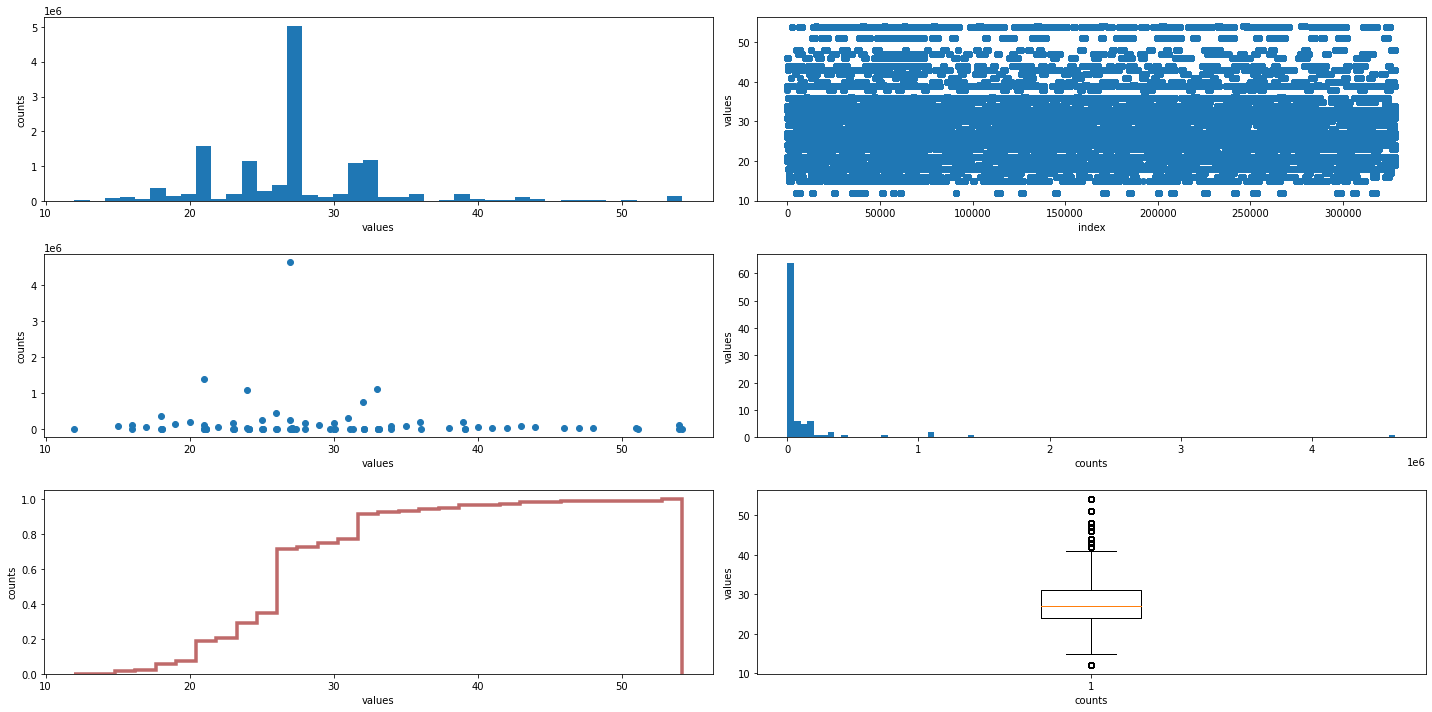

CPU times: user 28.1 s, sys: 2.61 s, total: 30.7 s
Wall time: 45.7 s


In [59]:
%%time
print(stats.describe(filtered_bbdd.capacity))
filtered_bbdd.capacity.describe()
show_counts(filtered_bbdd.capacity.compute())

## 'ctx0'

DescribeResult(nobs=13695947, minmax=(0.0, 1.0), mean=0.570643645803323, variance=0.0834411115547555, skewness=-0.3569097048050569, kurtosis=-1.0164593447381318)


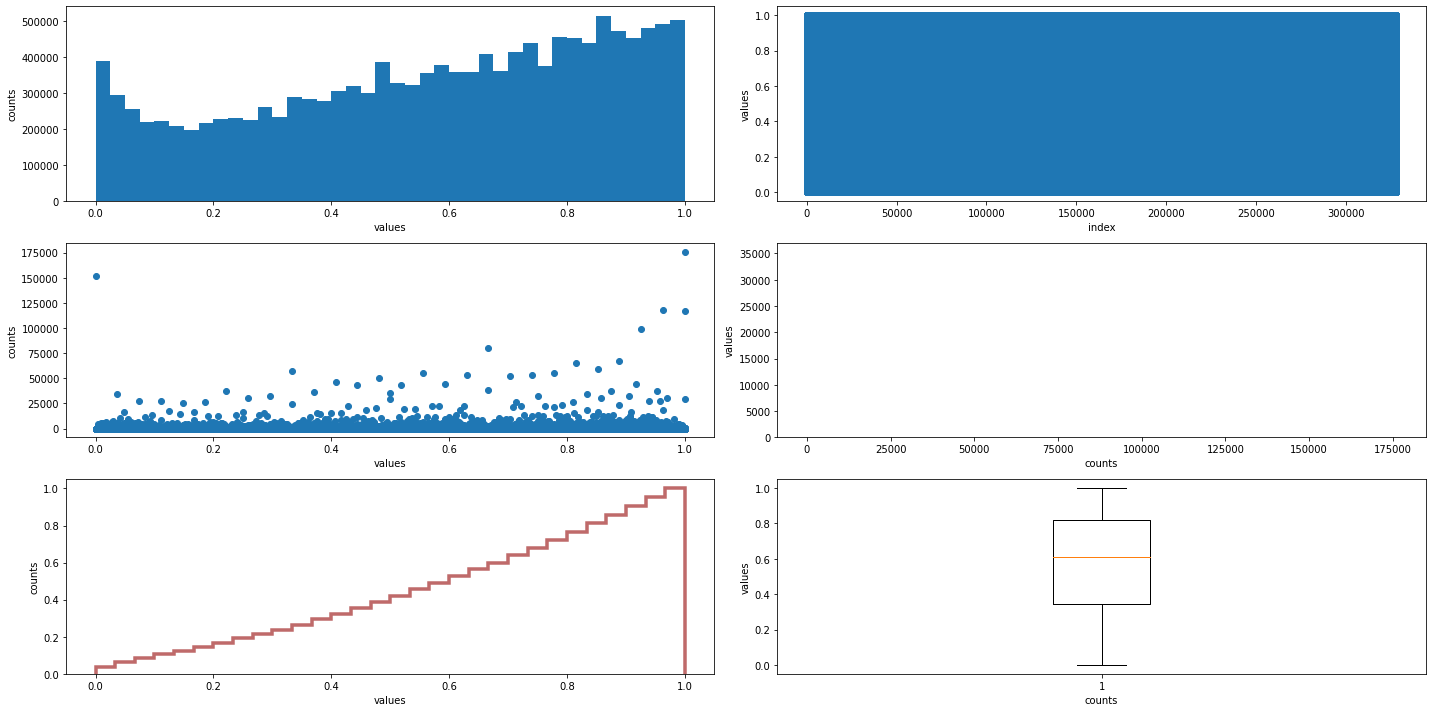

CPU times: user 3min 6s, sys: 18.5 s, total: 3min 24s
Wall time: 3min 34s


In [60]:
%%time
print(stats.describe(filtered_bbdd.ctx0))
filtered_bbdd.ctx0.describe()
show_counts(filtered_bbdd.ctx0.compute())

## · Visualización de la disponibilidad de bicicletas
Gráficos para visualizar la disponibilidad de bicicletas a lo largo del tiempo. Ejemplo: cantidad de bicicletas disponibles en función del tiempo para identificar patrones diarios, semanales o estacionales.

## · Análisis temporal
Datos por año, mes, día de la semana o hora del día para conocer estadísticas agregadas, como el promedio de bicicletas disponibles o el porcentaje de anclajes disponibles. Tendencias temporales y patrones de uso.

## · Relación entre variables
Explorar si hay una correlación entre el número de anclajes disponibles (num_docks_available) y el número de bicicletas disponibles (num_bikes_available). Investigar si la disponibilidad de bicicletas difiere entre los diferentes tipos de bicicletas (mecánicas y eléctricas).

## · Análisis de capacidad y porcentaje de anclajes disponibles
Capacidad (capacity) y los porcentajes de anclajes disponibles (ctx0, ctx1, ctx2, ctx3, ctx4). Promedio distribución de la capacidad y los porcentajes de anclajes disponibles. Objetivo: entender la utilización de las estaciones de bicicletas a lo largo del tiempo.

## Data Cleaning

In [43]:
config = pd.Series({
    'path': os.path.abspath('dades'),
    'file_type':'csv',
    'years':[2019, 2021, 2022],
    'dataset': 'BicingNou_ESTACIONS_MOD'
})

bbdd_completa = read_data_all(config)   

checkpoint reloaded.
checkpoint reloaded.
checkpoint reloaded.


In [44]:
before = get_ddf_shape(bbdd_completa)
before

(12419994, 23)

In [45]:
bbdd_completa.columns


Index(['station_id', 'num_docks_available', 'num_bikes_available', 'status',
       'timestamp', 'is_installed', 'is_renting', 'is_returning',
       'is_charging_station', 'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'year', 'month', 'dayofweek', 'day',
       'dayofyear', 'hour', 'capacity', 'ctx0', 'ctx1', 'ctx2', 'ctx3',
       'ctx4'],
      dtype='object')

In [46]:
%%time
# error fix
# 2019 gener, febrer and marc have the status reversed 

cond = (bbdd_completa.year == 2019) & (bbdd_completa.month.isin([1,2,3]))

bbdd_completa['status'] = bbdd_completa['status'].mask(cond, ((bbdd_completa['status'] + 1) %2))


CPU times: user 10.8 ms, sys: 0 ns, total: 10.8 ms
Wall time: 10.4 ms


In [47]:
%%time

bbdd_completa = bbdd_completa.drop(columns=['is_charging_station'])

# Found two station with alot of missing values 
# best solution is to remove
condition = (bbdd_completa['year'].isin([2020]))
bbdd_completa = bbdd_completa.mask(condition, np.nan)
bbdd_completa = bbdd_completa.dropna(subset=['year'])


CPU times: user 14.5 ms, sys: 9.23 ms, total: 23.7 ms
Wall time: 22.5 ms


In [48]:
after = get_ddf_shape(bbdd_completa)
after

(12419489, 22)

In [49]:
print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(after[0]-before[0]):02d} rows')
print(f'dropped {(after[1]-before[1]):02d} columns')

Changes to dataframe durinf preprocessing
dropeed -505 rows
dropped -1 columns


In [50]:
%%time

unique_ids_by_year = bbdd_completa.groupby('year')['station_id'].unique().compute()
print(unique_ids_by_year)

# Calcula los station_id comunes en todos los años
common_ids = set(unique_ids_by_year[2019])
for year, ids in unique_ids_by_year.items():
    print(year, ids.shape)
    common_ids = common_ids.intersection(set(ids))
# common_ids
print(len(common_ids))

filtered_bbdd = bbdd_completa[bbdd_completa['station_id'].isin(common_ids)]
nonfiltered_bbdd = bbdd_completa[~bbdd_completa['station_id'].isin(common_ids)]

year
2019.0    [1, 320, 319, 318, 317, 316, 315, 314, 313, 31...
2021.0    [1.0, 271.0, 400.0, 510.0, 26.0, 270.0, 269.0,...
2022.0    [1, 380, 28, 379, 378, 377, 376, 375, 29, 374,...
Name: station_id, dtype: object
2019.0 (410,)
2021.0 (509,)
2022.0 (510,)
408
CPU times: user 1.23 s, sys: 190 ms, total: 1.42 s
Wall time: 7.71 s


In [66]:
%%time

stations = filtered_bbdd[['timestamp', 'station_id', 'ctx0']].compute()

CPU times: user 1.39 s, sys: 359 ms, total: 1.75 s
Wall time: 7.66 s


In [98]:
%%time 

# test 

cond = stations.station_id.isin([1])
station_data = stations[cond]
station_group = station_data.groupby(['timestamp', 'station_id'])
station_counts = station_group.ctx0.count()
station_mean = station_group.ctx0.mean()
(station_counts > 1).any()

CPU times: user 10.4 ms, sys: 9.91 ms, total: 20.3 ms
Wall time: 19.2 ms


True

In [99]:
station_counts = station_counts.reset_index()
station_counts

,timestamp,station_id,ctx0
0,1.546301e+09,1.0,1
1,1.546304e+09,1.0,1
2,1.546308e+09,1.0,1
3,1.546312e+09,1.0,1
4,1.546315e+09,1.0,1
...,...,...,...
25939,1.672513e+09,1.0,1
25940,1.672517e+09,1.0,1
25941,1.672520e+09,1.0,1
25942,1.672524e+09,1.0,1


In [104]:
station_counts.timestamp.to_list()

[1546300800.0,
 1546304400.0,
 1546308000.0,
 1546311600.0,
 1546315200.0,
 1546318800.0,
 1546322400.0,
 1546326000.0,
 1546329600.0,
 1546333200.0,
 1546336800.0,
 1546340400.0,
 1546344000.0,
 1546347600.0,
 1546351200.0,
 1546354800.0,
 1546358400.0,
 1546362000.0,
 1546365600.0,
 1546369200.0,
 1546372800.0,
 1546376400.0,
 1546380000.0,
 1546383600.0,
 1546387200.0,
 1546390800.0,
 1546394400.0,
 1546398000.0,
 1546401600.0,
 1546405200.0,
 1546408800.0,
 1546412400.0,
 1546416000.0,
 1546419600.0,
 1546423200.0,
 1546426800.0,
 1546430400.0,
 1546434000.0,
 1546437600.0,
 1546441200.0,
 1546444800.0,
 1546448400.0,
 1546452000.0,
 1546455600.0,
 1546459200.0,
 1546462800.0,
 1546466400.0,
 1546470000.0,
 1546473600.0,
 1546477200.0,
 1546480800.0,
 1546484400.0,
 1546488000.0,
 1546491600.0,
 1546495200.0,
 1546498800.0,
 1546502400.0,
 1546506000.0,
 1546509600.0,
 1546513200.0,
 1546516800.0,
 1546520400.0,
 1546524000.0,
 1546527600.0,
 1546531200.0,
 1546534800.0,
 154653840

In [100]:
station_mean = station_mean.reset_index()
station_mean

,timestamp,station_id,ctx0
0,1.546301e+09,1.0,0.181818
1,1.546304e+09,1.0,0.156126
2,1.546308e+09,1.0,0.164032
3,1.546312e+09,1.0,0.191700
4,1.546315e+09,1.0,0.104743
...,...,...,...
25939,1.672513e+09,1.0,0.125604
25940,1.672517e+09,1.0,0.111801
25941,1.672520e+09,1.0,0.119565
25942,1.672524e+09,1.0,0.158385


In [102]:
station_mean[(station_counts.ctx0 > 1)]

,timestamp,station_id,ctx0
743,1.548976e+09,1.0,0.630435
744,1.548979e+09,1.0,0.630435
745,1.548983e+09,1.0,0.630435
746,1.548986e+09,1.0,0.630435
747,1.548990e+09,1.0,0.630435
...,...,...,...
25199,1.669849e+09,1.0,0.396739
25200,1.669853e+09,1.0,0.327899
25201,1.669856e+09,1.0,0.302536
25202,1.669860e+09,1.0,0.304348


In [105]:
%%time

stations = filtered_bbdd[['timestamp', 'station_id', 'ctx0']].compute()

bad_stations = []
good_stations = []
deleted_stations = []

for station_id in tqdm(uniques['station_id']): 
    cond = stations.station_id.isin([station_id])
    station_data = stations[cond]
    if cond.any():
        station_group = station_data.groupby(['timestamp', 'station_id'])
        station_counts = station_group.ctx0.count()
        station_mean = station_group.ctx0.mean()
        if (station_counts > 1).any():
            #print(station_id)
            bad_stations.append(station_id)
        else:
            good_stations.append(station_id)
    else: 
        deleted_stations.append(station_id)
        

  0%|          | 0/512 [00:00<?, ?it/s]

CPU times: user 9.11 s, sys: 572 ms, total: 9.68 s
Wall time: 15.5 s


In [106]:
bad_stations

[1,
 320,
 319,
 318,
 317,
 316,
 315,
 314,
 313,
 312,
 311,
 310,
 321,
 309,
 307,
 306,
 305,
 304,
 303,
 302,
 301,
 300,
 299,
 298,
 297,
 308,
 322,
 323,
 324,
 349,
 348,
 347,
 346,
 345,
 344,
 343,
 342,
 341,
 340,
 339,
 338,
 337,
 336,
 335,
 334,
 333,
 332,
 331,
 329,
 328,
 327,
 326,
 325,
 296,
 350,
 295,
 292,
 261,
 260,
 259,
 258,
 256,
 255,
 254,
 253,
 252,
 251,
 250,
 262,
 249,
 247,
 246,
 244,
 243,
 242,
 241,
 240,
 239,
 238,
 237,
 236,
 248,
 263,
 264,
 265,
 291,
 289,
 288,
 287,
 286,
 285,
 284,
 283,
 282,
 281,
 280,
 279,
 278,
 277,
 276,
 275,
 274,
 273,
 272,
 271,
 270,
 269,
 268,
 267,
 266,
 294,
 352,
 353,
 354,
 428,
 427,
 426,
 425,
 424,
 423,
 421,
 420,
 496,
 495,
 494,
 492,
 419,
 418,
 416,
 415,
 381,
 380,
 378,
 377,
 376,
 375,
 374,
 373,
 372,
 371,
 370,
 369,
 368,
 367,
 365,
 364,
 363,
 362,
 361,
 360,
 359,
 358,
 356,
 382,
 235,
 384,
 386,
 414,
 413,
 412,
 410,
 409,
 408,
 406,
 405,
 404,
 402,


In [107]:
good_stations

[]

In [108]:
deleted_stations

[93,
 59,
 472,
 471,
 474,
 379,
 469,
 383,
 43,
 481,
 482,
 436,
 480,
 403,
 455,
 435,
 464,
 484,
 489,
 422,
 486,
 417,
 477,
 483,
 457,
 461,
 478,
 507,
 454,
 451,
 508,
 516,
 429,
 463,
 462,
 485,
 432,
 476,
 479,
 510,
 509,
 460,
 434,
 443,
 491,
 515,
 473,
 487,
 440,
 466,
 411,
 511,
 475,
 505,
 448,
 506,
 488,
 447,
 355,
 514,
 445,
 439,
 438,
 444,
 442,
 470,
 512,
 437,
 468,
 441,
 446,
 493,
 245,
 459,
 517,
 519,
 497,
 498,
 77,
 504,
 501,
 518,
 433,
 499,
 513,
 330,
 430,
 500,
 456,
 449,
 399,
 458,
 10,
 490,
 366,
 452,
 450,
 465,
 502,
 503,
 91,
 467,
 52,
 431]

In [113]:
stations.columns

Index(['timestamp', 'station_id', 'ctx0'], dtype='object')

In [109]:
stations.shape

(10627655, 3)

In [110]:
get_ddf_shape(filtered_bbdd)

(10627655, 22)

In [115]:
stations.drop_duplicates(subset=['timestamp', 'station_id'], keep='last', inplace=True)

In [116]:
stations.shape

(10526888, 3)

In [ ]:
## TODO
.

In [ ]:
# Found two station with alot of missing values 
# best solution is to remove
condition = (filtered_bbdd['year'].isin([2020]))
filtered_bbdd = filtered_bbdd.mask(condition, np.nan)
filtered_bbdd = filtered_bbdd.dropna(subset=['year'])

# Predicción__________________________________
a) Regresión lineal: relación lineal entre las variables de entrada y la variable de salida. 

b) Regresión Redes Neuronales (RNN -redes neuronales recurrentes-): pueden capturar relaciones no lineales entre las variables de entrada y salida.

In [ ]:
def get_pipeline(args):
    num0_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="mean")),
        ('log',FunctionTransformer(np.log1p, validate=True)),
        ('std_scaler', StandardScaler()),
    ])

    num1_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="mean")),
        ('rep',FunctionTransformer(np.log1p, validate=True)),# Cambie el reciprocal por el log1p pero al parecer para valores que no tienen historia se afecta mucho
        ('std_scaler', StandardScaler()),
    ])
    
    num2_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="mean")),
#         ('rep',FunctionTransformer(np.reciprocal, validate=True)),
        ('std_scaler', StandardScaler()),
    ])

    cat0_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="constant",fill_value='Unknown')),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
    ])

    cat1_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
#         ('std_scaler', StandardScaler()),
    ])

    ## the features
    weather_columns_by_months = [ 
        "EROSION_SUELO","PrecipAmountLocalMonth","TemperatureLocalMonthtimeMax","UVIndexLocalMonthMax"
    ]
    
    num_attribs0 = ["SUPERFICIE"]
    num_attribs2 = ["MALTITUD"]
    # num_attribs1 = weather_columns_by_months
    cat_attribs0 = ["RANGO_ALTITUD","VARIEDAD","ID_ESTACION","ID_ZONA","ID_FINCA", 'MODO']
    cat_attribs1 = ['TIPO','COLOR']
    
    full_pipeline = ColumnTransformer([
        ("num0", num0_pipeline, num_attribs0),
        ("num2", num2_pipeline, num_attribs2),
        ("cat0", cat0_pipeline, cat_attribs0),
        ("cat1", cat1_pipeline, cat_attribs1),
    ])
    
    return full_pipeline

def apply_pipeline(x_train,x_test,y_train,y_test, show=True):
    
    full_pipeline = get_pipeline({'campaña_catagories':[x_train.CAMPAÑA.unique().tolist() +x_test.CAMPAÑA.unique().tolist()],'fill_value':x_test.CAMPAÑA.unique()[-1],'unknown_value':x_train.CAMPAÑA.unique().shape[0]})

    x_train_prepared = full_pipeline.fit_transform(x_train)
    x_test_prepared = full_pipeline.transform(x_test)
    
    if show:
        print("x_train_prepared:",x_train_prepared.shape,"y_train: ",y_train.shape)
        print("x_test_prepared:",x_test_prepared.shape,"y_test: ",y_test.shape)

    return x_train_prepared,x_test_prepared,y_train,y_test

def split_data(X, show=True):
    
    df = X.copy()
    
    cond_train = df.CAMPAÑA<df.CAMPAÑA.unique()[-1]
    cond_test = df.CAMPAÑA.isin([df.CAMPAÑA.unique()[-1]])

    x_train = df[cond_train].loc[:,~df.columns.isin(["PRODUCCION"])]
    x_test = df[cond_test].loc[:,~df.columns.isin(["PRODUCCION"])]
    y_train = df[cond_train].loc[:,df.columns.isin(["PRODUCCION"])]
    y_test = df[cond_test].loc[:,df.columns.isin(["PRODUCCION"])]
    
    if show:
        print("x_train:",x_train.shape,"y_train: ",y_train.shape)
        print("x_test:",x_test.shape,"y_test: ",y_test.shape)
    
    return x_train,x_test,y_train,y_test

In [ ]:
df = data[~data.CAMPAÑA.isin([22,14])]
x_train,x_test,y_train,y_test = split_data(df)
x_train_prepared,x_test_prepared,y_train,y_test = apply_pipeline(x_train,x_test,y_train,y_test)


In [ ]:
final_model = RandomForestRegressor(max_depth=100, min_samples_split=4,random_state=42, n_estimators=60) #(OK)

# final_model = GradientBoostingRegressor(max_depth=22, min_samples_split=2,min_samples_leaf=2, max_features= 'sqrt',random_state=0) #(OK)

final_model.fit(x_train_prepared,y_train)

test_model(final_model, x_train_prepared, y_train, x_test_prepared, y_test)

pred = final_model.predict(x_test_prepared)

df["PRODUCCION_PRED"] = df["PRODUCCION"].copy()
df.loc[x_test.index,"PRODUCCION_PRED"]=pred


# Datos adicionales
Tiempo, festivos Barcelona